## Importing Libraries and Train Data

In [2]:
# Importing essential libraries
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
pd. set_option('display.max_columns', None)
pd. set_option('display.max_rows', 50)
sns.set(rc={'figure.figsize':(15,10)})
import warnings
warnings.filterwarnings("ignore") # for statistical data visualization
%matplotlib inline

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score

In [4]:
# Importing Account Data
with open('train/accounts_data_train.json', 'r') as f:
    accounts_train_json = json.load(f)
accounts_train_json2 = [entry for sublist in accounts_train_json for entry in sublist]   
accounts_train_df = pd.DataFrame(accounts_train_json2)
print(accounts_train_df.shape)
accounts_train_df.head()

(1245310, 7)


,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [5]:
# Importing Enquiry Data
with open('train/enquiry_data_train.json', 'r') as f:
    enquiry_train_json = json.load(f)
enquiry_train_json2 = [entry for sublist in enquiry_train_json for entry in sublist]   
enquiry_train_df = pd.DataFrame(enquiry_train_json2)
print(enquiry_train_df.shape)                               
enquiry_train_df.head()


(1909926, 4)


,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [6]:
# importing flag data which contains our Target variable
flag_train_df=pd.read_csv('train/train_flag.csv')
print(flag_train_df.shape)
flag_train_df.head(3)

(261383, 3)


,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0


## EDA & Feature Engineering

In [7]:
# checking for null values
print(flag_train_df.isnull().sum())

uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64


In [8]:
# checking Target class distribution
flag_train_df.TARGET.value_counts()

0    240326
1     21057
Name: TARGET, dtype: int64

In [9]:
flag_train_df.TARGET.value_counts(1)

0    0.91944
1    0.08056
Name: TARGET, dtype: float64

In [10]:
flag_train_df.NAME_CONTRACT_TYPE.value_counts()

Cash loans         236524
Revolving loans     24859
Name: NAME_CONTRACT_TYPE, dtype: int64

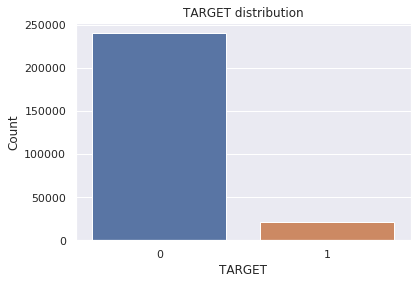

In [11]:
# Plotting Target class distribution
sns.countplot(x='TARGET', data=flag_train_df)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.title('TARGET distribution')
plt.show()

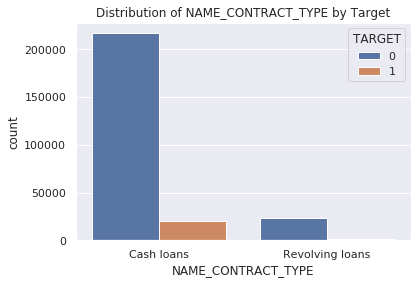

In [12]:
#plotting Contract Type distibution by Target variable
categorical_features = ['NAME_CONTRACT_TYPE']
for feature in categorical_features:
    sns.countplot(x=feature, hue='TARGET', data=flag_train_df)
    plt.title(f'Distribution of {feature} by Target')
    plt.show()

In [13]:
print('Total Account Data'+ str(accounts_train_df.shape[0]))
print('Unique ids '+str(accounts_train_df['uid'].nunique()))

Total Account Data1245310
Unique ids 223918


In [14]:
print('Total Enquiry Data '+ str(enquiry_train_df.shape[0]))
print('Unique ids '+str(enquiry_train_df['uid'].nunique()))

Total Enquiry Data 1909926
Unique ids 261383


### Account Data Feature engineering

In [15]:
# Exploring given data
accounts_train_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [16]:
accounts_train_df.describe()

,loan_amount,amount_overdue
count,1.245307e+06,1.245310e+06
mean,3.523541e+05,4.202288e+01
std,1.109812e+06,6.668687e+03
min,0.000000e+00,0.000000e+00
25%,5.114700e+04,0.000000e+00
50%,1.246590e+05,0.000000e+00
75%,3.087000e+05,0.000000e+00
max,3.960000e+08,3.756681e+06


In [17]:
accounts_train_df.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [18]:
# Dropping 3 rows containing null values in loan_amount
accounts_train_df.dropna(subset=['loan_amount'],inplace=True)

In [19]:
# Exploring given columns
accounts_train_df.columns

Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid'],
      dtype='object')

In [20]:
# Function to extract repayment history from payment string for each month
def extract_monthly_repayment_history(payment_hist_string):
    # Convert string to list of integers since each month is denoted by 3 numbers
    payments = [int(payment_hist_string[i:i+3]) for i in range(0, len(payment_hist_string), 3)]
    return payments

accounts_train_df['monthly_repayment_history'] = accounts_train_df['payment_hist_string'].apply(extract_monthly_repayment_history)

In [21]:
accounts_train_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,monthly_repayment_history
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,"[0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0,..."
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,"[0, 0, 0, 0, 0, 14, 44, 0, 0, 0, 0, 0, 0, 0, 0..."
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,"[0, 0, 0, 0, 0, 0]"
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,"[0, 0, 0]"
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
# Calculating number of overdue payments, total payments & minimum,maximum and average number of overdue payments
def calculate_summary_stats(repayment_history):
    #checking for non-null values
    if len(repayment_history) > 0:
    # Calculate number of overdue payments
        overdue_count = sum(1 for days in repayment_history if days > 0)
        # Calculate total payments
        total_payments = len(repayment_history)
        # Calculate minimum,maximum and average number of overdue payments
        avg_overdue_days = np.mean(repayment_history)
        max_overdue_days = np.max(repayment_history)
        min_overdue_days = np.min(repayment_history)
        return  avg_overdue_days, min_overdue_days, max_overdue_days,overdue_count, total_payments
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan

# Applying the function to create new features
accounts_train_df['avg_overdue_days'], accounts_train_df['min_overdue_days'],accounts_train_df['max_overdue_days'],accounts_train_df['overdue_count'],accounts_train_df['total_payments'] = \
    zip(*accounts_train_df['monthly_repayment_history'].apply(calculate_summary_stats))

In [23]:
accounts_train_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,monthly_repayment_history,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,"[0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0,...",0.588235,0.0,10.0,1.0,17.0
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,"[0, 0, 0, 0, 0, 14, 44, 0, 0, 0, 0, 0, 0, 0, 0...",3.625000,0.0,44.0,2.0,16.0
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,"[0, 0, 0, 0, 0, 0]",0.000000,0.0,0.0,0.0,6.0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,"[0, 0, 0]",0.000000,0.0,0.0,0.0,3.0
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",190.486842,0.0,917.0,31.0,76.0


In [24]:
# Creating 'active_loan' column
accounts_train_df['active_loan'] = accounts_train_df['closed_date'].isnull().astype(int)
# Creating 'inactive_loan' column
accounts_train_df['inactive_loan'] = (~accounts_train_df['closed_date'].isnull()).astype(int)

In [25]:
# Converting date columns into the desired format
accounts_train_df['closed_date'].fillna('2024-04-09',inplace=True) # to calculate loan duration
accounts_train_df['closed_date']=pd.to_datetime(accounts_train_df['closed_date']).dt.date
accounts_train_df['closed_date']=pd.to_datetime(accounts_train_df['closed_date'])

accounts_train_df['open_date']=pd.to_datetime(accounts_train_df['open_date']).dt.date
accounts_train_df['open_date']=pd.to_datetime(accounts_train_df['open_date'])

In [26]:
# Calculating loan duration
accounts_train_df['loan_duration'] = (accounts_train_df['closed_date'] - accounts_train_df['open_date']).dt.days

In [27]:
# checking credit type distibution
accounts_train_df['credit_type'].value_counts()

Consumer credit                                 908741
Credit card                                     292422
Car loan                                         20237
Mortgage                                         13196
Microloan                                         7766
Loan for business development                     1466
Another type of loan                               729
Unknown type of loan                               374
Loan for working capital replenishment             320
Real estate loan                                    17
Cash loan (non-earmarked)                           17
Loan for the purchase of equipment                  16
Loan for purchase of shares (margin lending)         4
Interbank credit                                     1
Mobile operator loan                                 1
Name: credit_type, dtype: int64

In [28]:
# checking credit type distibution in percentage
accounts_train_df['credit_type'].value_counts(1)

Consumer credit                                 7.297325e-01
Credit card                                     2.348192e-01
Car loan                                        1.625061e-02
Mortgage                                        1.059658e-02
Microloan                                       6.236213e-03
Loan for business development                   1.177220e-03
Another type of loan                            5.853978e-04
Unknown type of loan                            3.003275e-04
Loan for working capital replenishment          2.569647e-04
Real estate loan                                1.365125e-05
Cash loan (non-earmarked)                       1.365125e-05
Loan for the purchase of equipment              1.284824e-05
Loan for purchase of shares (margin lending)    3.212059e-06
Interbank credit                                8.030148e-07
Mobile operator loan                            8.030148e-07
Name: credit_type, dtype: float64

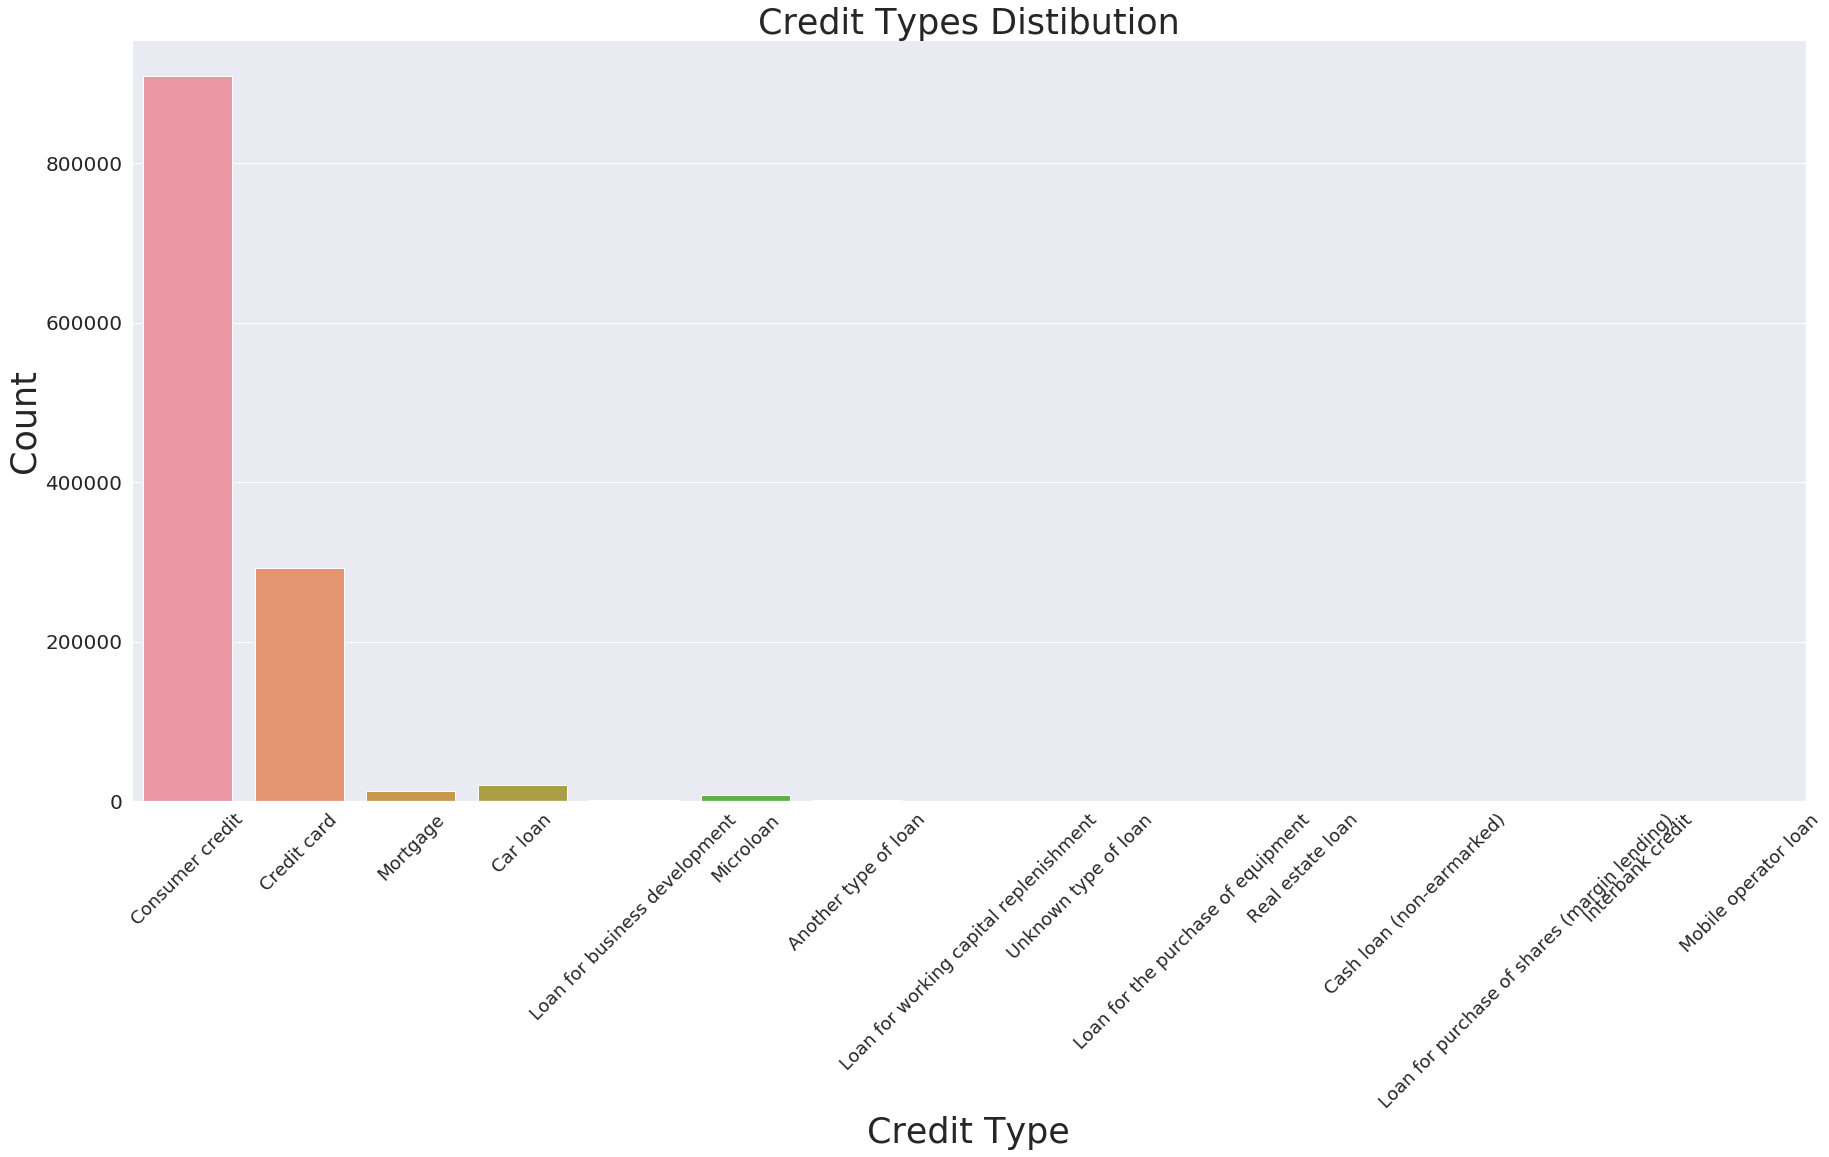

In [29]:
# Ploting disribution for credit_type
plt.figure(figsize=(30, 14))
sns.countplot(x='credit_type', data=accounts_train_df)
plt.title('Credit Types Distibution', fontsize=35)  
plt.xlabel('Credit Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=20)
plt.show()

In [30]:
#Getting the top 5 most frequent categories
top_categories = accounts_train_df['credit_type'].value_counts().head(5).index.tolist()

# Replace all other categories with 'other'
accounts_train_df['credit_type'] = accounts_train_df['credit_type'].apply(lambda x: x if x in top_categories else 'other_loan')

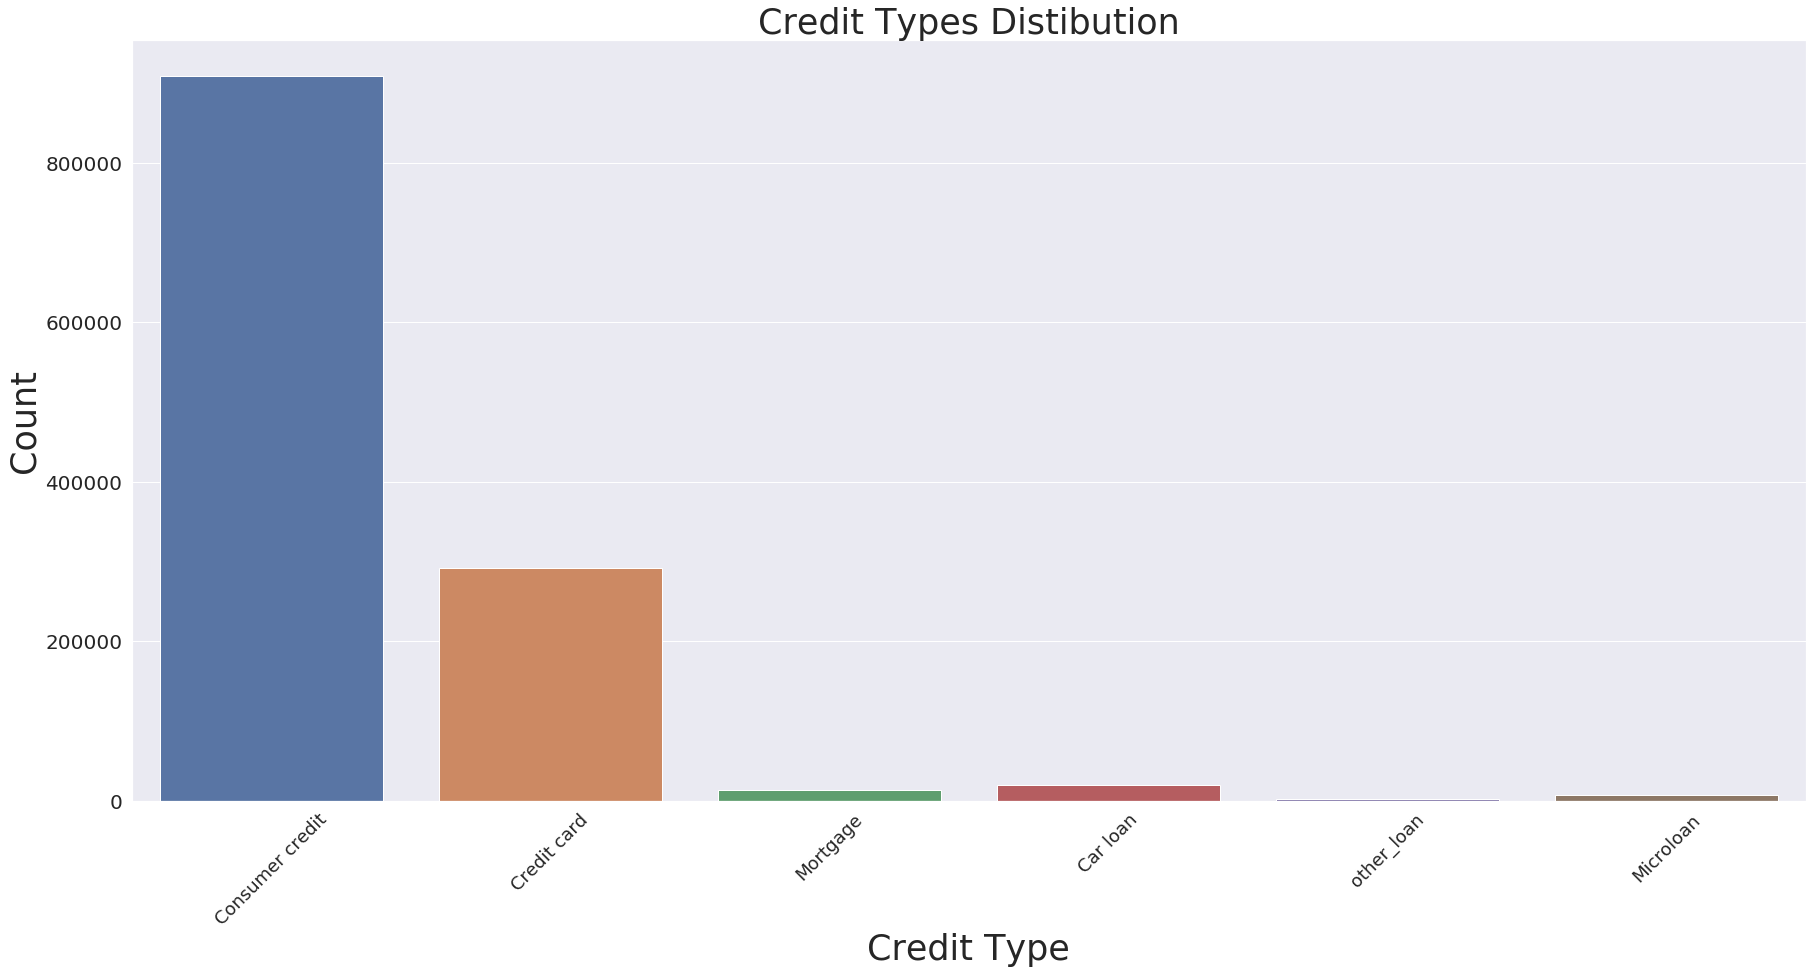

In [31]:
# Ploting disribution for credit_type
plt.figure(figsize=(30, 14))
sns.countplot(x='credit_type', data=accounts_train_df)
plt.title('Credit Types Distibution', fontsize=35)  
plt.xlabel('Credit Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=20)
plt.show()

In [32]:
accounts_train_df.credit_type.value_counts()

Consumer credit    908741
Credit card        292422
Car loan            20237
Mortgage            13196
Microloan            7766
other_loan           2945
Name: credit_type, dtype: int64

In [33]:
credit_type_dummies = pd.get_dummies(accounts_train_df['credit_type'], prefix='credit_type')
# Concatenating the binary indicator columns with the original DataFrame
accounts_train_df = pd.concat([accounts_train_df, credit_type_dummies], axis=1)
# Dropping the original 'credit_type' column
accounts_train_df.drop(columns=['credit_type'], inplace=True)

In [34]:
accounts_train_df.columns

Index(['loan_amount', 'amount_overdue', 'open_date', 'closed_date',
       'payment_hist_string', 'uid', 'monthly_repayment_history',
       'avg_overdue_days', 'min_overdue_days', 'max_overdue_days',
       'overdue_count', 'total_payments', 'active_loan', 'inactive_loan',
       'loan_duration', 'credit_type_Car loan', 'credit_type_Consumer credit',
       'credit_type_Credit card', 'credit_type_Microloan',
       'credit_type_Mortgage', 'credit_type_other_loan'],
      dtype='object')

In [35]:
# Using aggregation functions for each feature to get data on 'uid' level
#consdering top 5 credit type + unknown and other_type loans
aggregation_functions = {
    'loan_amount': 'sum',
    'open_date':'count',
    'active_loan':'sum',
    'inactive_loan':'sum',
    'amount_overdue': 'sum',
    'avg_overdue_days': 'mean',
    'min_overdue_days': 'min',
    'max_overdue_days': 'max',
    'overdue_count': 'sum',
    'total_payments': 'sum',
    'loan_duration': 'mean',
    'credit_type_Consumer credit': 'sum',
    'credit_type_Credit card': 'sum',
    'credit_type_Microloan': 'sum',
    'credit_type_Mortgage': 'sum',
    'credit_type_Car loan': 'sum',
    'credit_type_other_loan': 'sum'
}
accounts_train_df2 = accounts_train_df.groupby('uid').agg(aggregation_functions).reset_index()
accounts_train_df2.rename(columns={'open_date': 'total_loans','loan_duration': 'avg_loan_duration'}, inplace=True)
accounts_train_df2.columns = accounts_train_df2.columns.str.replace('credit_type_', 'number_of_').str.replace(' ', '_')

In [36]:
accounts_train_df2.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan
0,AAA09044550,277245.000,2,0,2,0.0,2.106618,0.0,44.0,3.0,33.0,511.0,2,0,0,0,0,0
1,AAA10545297,80996.445,1,1,0,0.0,0.000000,0.0,0.0,0.0,6.0,1380.0,0,1,0,0,0,0
2,AAA14112888,43771.500,1,0,1,0.0,0.000000,0.0,0.0,0.0,3.0,92.0,1,0,0,0,0,0
3,AAA20326915,591597.000,8,3,5,0.0,23.810855,0.0,917.0,31.0,151.0,1025.5,5,3,0,0,0,0
4,AAA31604840,1591960.500,5,3,2,0.0,0.000000,0.0,0.0,0.0,78.0,1200.2,4,1,0,0,0,0


In [37]:
#converting average overdue days to upto 3 decimal places
accounts_train_df2['avg_overdue_days'] = np.round(accounts_train_df2['avg_overdue_days'],3)

In [38]:
#Checking whether customer has the given credit type or not
accounts_train_df2['consumer_credit']=np.where(accounts_train_df2['number_of_Consumer_credit']>0,1,0)
accounts_train_df2['credit_card']=np.where(accounts_train_df2['number_of_Credit_card']>0,1,0)
accounts_train_df2['car_loan']=np.where(accounts_train_df2['number_of_Car_loan']>0,1,0)
accounts_train_df2['mortgage']=np.where(accounts_train_df2['number_of_Mortgage']>0,1,0)
accounts_train_df2['microloan']=np.where(accounts_train_df2['number_of_Microloan']>0,1,0)
accounts_train_df2['other_loan']=np.where(accounts_train_df2['number_of_other_loan']>0,1,0)

In [39]:
accounts_train_df2.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan
0,AAA09044550,277245.000,2,0,2,0.0,2.107,0.0,44.0,3.0,33.0,511.0,2,0,0,0,0,0,1,0,0,0,0,0
1,AAA10545297,80996.445,1,1,0,0.0,0.000,0.0,0.0,0.0,6.0,1380.0,0,1,0,0,0,0,0,1,0,0,0,0
2,AAA14112888,43771.500,1,0,1,0.0,0.000,0.0,0.0,0.0,3.0,92.0,1,0,0,0,0,0,1,0,0,0,0,0
3,AAA20326915,591597.000,8,3,5,0.0,23.811,0.0,917.0,31.0,151.0,1025.5,5,3,0,0,0,0,1,1,0,0,0,0
4,AAA31604840,1591960.500,5,3,2,0.0,0.000,0.0,0.0,0.0,78.0,1200.2,4,1,0,0,0,0,1,1,0,0,0,0


In [40]:
accounts_train_df2.shape

(223917, 24)

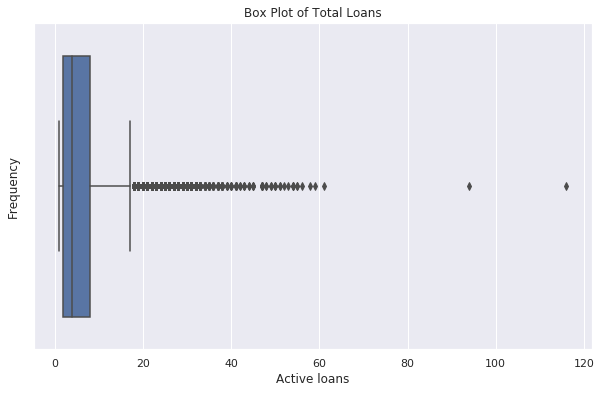

In [41]:
# Plotting box plot for number of  loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='total_loans', data=accounts_train_df2)
plt.title('Box Plot of Total Loans')
plt.xlabel('Active loans')
plt.ylabel('Frequency')
plt.show()

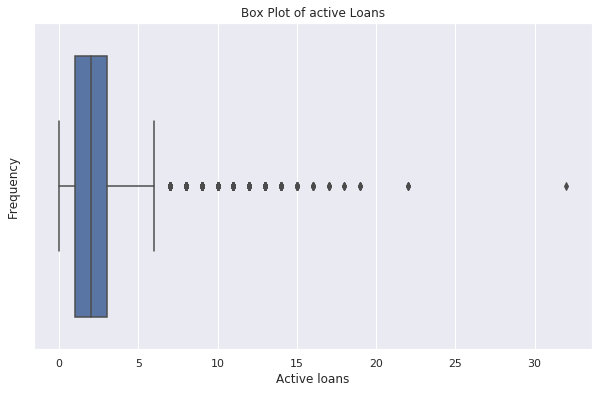

In [42]:
# Plotting box plot for number of active loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='active_loan', data=accounts_train_df2)
plt.title('Box Plot of active Loans')
plt.xlabel('Active loans')
plt.ylabel('Frequency')
plt.show()

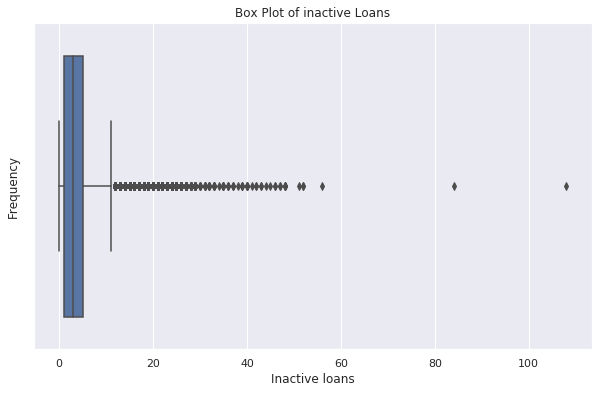

In [43]:
# Plotting box plot for number of active loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='inactive_loan', data=accounts_train_df2)
plt.title('Box Plot of inactive Loans')
plt.xlabel('Inactive loans')
plt.ylabel('Frequency')
plt.show()

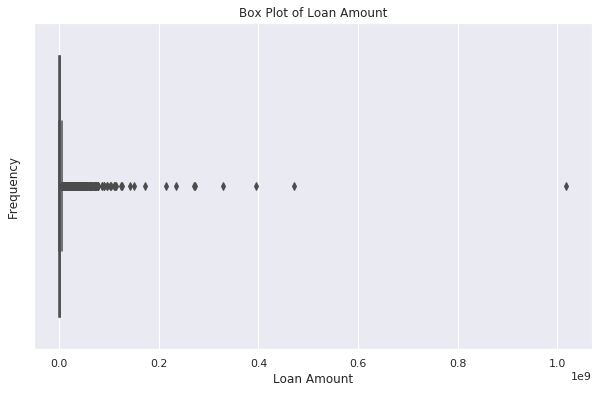

In [44]:
# Plotting box plot for loan amount
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_amount', data=accounts_train_df2)
plt.title('Box Plot of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

### Enquiry Data Feature engineering

In [45]:
enquiry_train_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [46]:
print('Total Enquiry Data '+ str(enquiry_train_df.shape[0]))
print('Unique ids '+str(enquiry_train_df['uid'].nunique()))

Total Enquiry Data 1909926
Unique ids 261383


In [47]:
# checking distibution for enquiry types
enquiry_train_df['enquiry_type'].value_counts()

Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: enquiry_type, dtype: int64

In [48]:
# checking distibution for enquiry types in percentage
enquiry_train_df['enquiry_type'].value_counts(1)

Cash loans                                      0.158701
Revolving loans                                 0.062924
Mobile operator loan                            0.052085
Real estate loan                                0.052006
Microloan                                       0.052004
Unknown type of loan                            0.051981
Loan for purchase of shares (margin lending)    0.051955
Mortgage                                        0.051948
Credit card                                     0.051943
Another type of loan                            0.051915
Loan for the purchase of equipment              0.051914
Interbank credit                                0.051867
Car loan                                        0.051831
Loan for business development                   0.051782
Cash loan (non-earmarked)                       0.051746
Loan for working capital replenishment          0.051737
Consumer credit                                 0.051659
Name: enquiry_type, dtype: floa

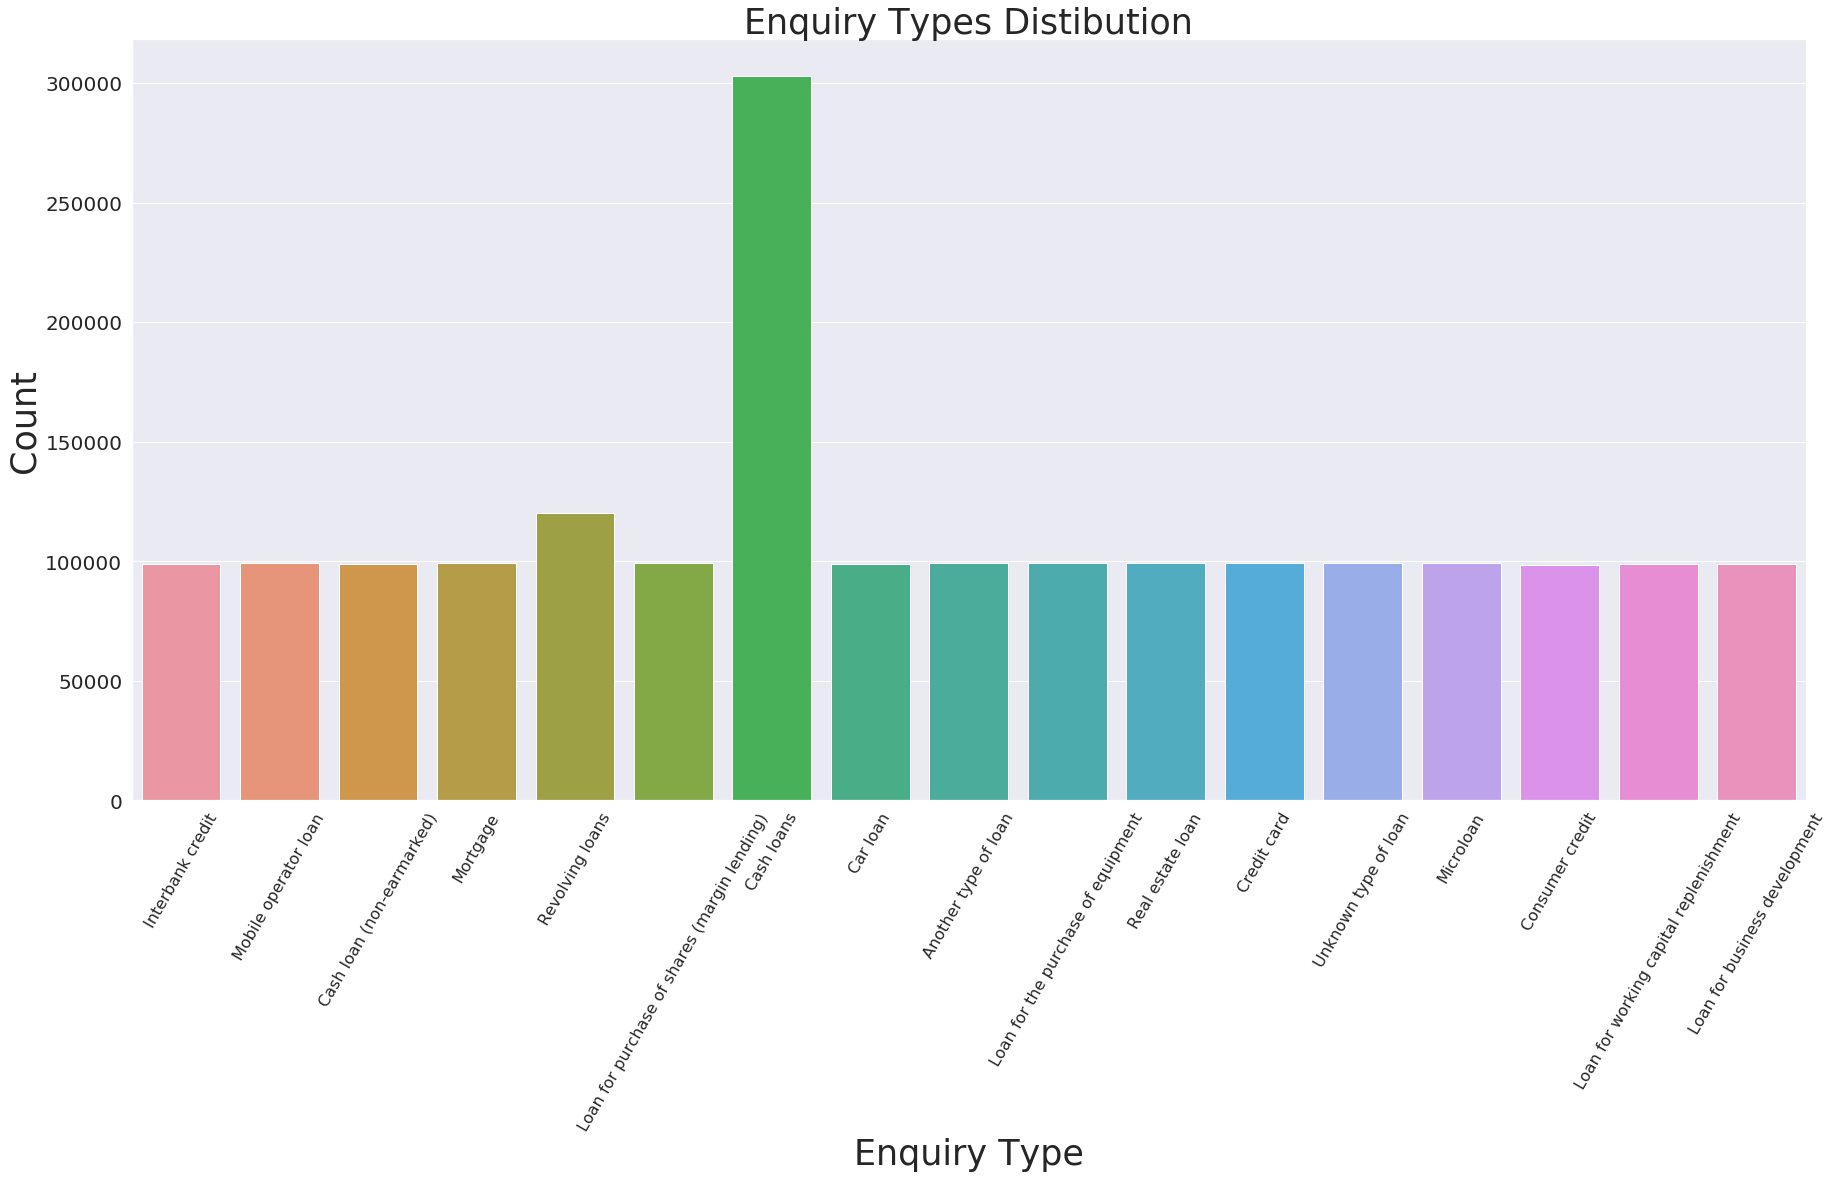

In [49]:
# Ploting distribution for 'enquiry_type'
plt.figure(figsize=(30, 14))
sns.countplot(x='enquiry_type', data=enquiry_train_df)
plt.title('Enquiry Types Distibution', fontsize=35)  
plt.xlabel('Enquiry Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=60, fontsize=16)
plt.yticks(fontsize=20)
plt.show()

In [50]:
# Creating binary indicator columns for each category in 'enquiry_type'
enquiry_dummies = pd.get_dummies(enquiry_train_df['enquiry_type'], prefix='enquiry')
# Concatenating the binary indicator columns with the original DataFrame
enquiry_train_df = pd.concat([enquiry_train_df, enquiry_dummies], axis=1)
# Dropping the original 'enquiry_type' column
enquiry_train_df.drop(columns=['enquiry_type'], inplace=True)

In [51]:
enquiry_train_df.head()

,enquiry_amt,enquiry_date,uid,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan
0,168839,2020-11-08,AAA08065248,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,268392,2020-09-20,AAA08065248,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,36082,2020-06-19,AAA08065248,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,180467,2019-10-22,AAA08065248,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,227459,2020-05-24,AAA08065248,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
enquiry_train_df.columns

Index(['enquiry_amt', 'enquiry_date', 'uid', 'enquiry_Another type of loan',
       'enquiry_Car loan', 'enquiry_Cash loan (non-earmarked)',
       'enquiry_Cash loans', 'enquiry_Consumer credit', 'enquiry_Credit card',
       'enquiry_Interbank credit', 'enquiry_Loan for business development',
       'enquiry_Loan for purchase of shares (margin lending)',
       'enquiry_Loan for the purchase of equipment',
       'enquiry_Loan for working capital replenishment', 'enquiry_Microloan',
       'enquiry_Mobile operator loan', 'enquiry_Mortgage',
       'enquiry_Real estate loan', 'enquiry_Revolving loans',
       'enquiry_Unknown type of loan'],
      dtype='object')

In [53]:
# Using aggregation functions for each feature to get data on 'uid' level
enquiry_aggregation_functions = {
    'enquiry_amt': 'sum',
    'enquiry_date': 'count',
    'enquiry_Another type of loan': 'sum',
    'enquiry_Car loan': 'sum',
    'enquiry_Cash loan (non-earmarked)': 'sum',
    'enquiry_Cash loans': 'sum',
    'enquiry_Consumer credit': 'sum',
    'enquiry_Credit card': 'sum',
    'enquiry_Interbank credit': 'sum',
    'enquiry_Loan for business development': 'sum',
    'enquiry_Loan for purchase of shares (margin lending)': 'sum',
    'enquiry_Loan for the purchase of equipment': 'sum',
    'enquiry_Loan for working capital replenishment': 'sum',
    'enquiry_Microloan': 'sum',
    'enquiry_Mobile operator loan': 'sum',
    'enquiry_Mortgage': 'sum',
    'enquiry_Real estate loan': 'sum',
    'enquiry_Revolving loans': 'sum',
    'enquiry_Unknown type of loan': 'sum'
}

# Aggregating the features on uid level
enquiry_train_df2 = enquiry_train_df.groupby('uid').agg(enquiry_aggregation_functions).reset_index()

# Renaming columns
enquiry_train_df2.rename(columns={'enquiry_amt': 'total_enquiry_amount', 'enquiry_date': 'num_enquiries'}, inplace=True)


In [54]:
enquiry_train_df2.head()

,uid,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan
0,AAA08065248,2064658,11,0,0,1,0,0,0,3,0,2,0,0,0,2,1,0,2,0
1,AAA09044550,2659000,26,3,3,1,7,1,1,2,0,0,1,0,2,1,1,1,1,1
2,AAA10545297,1317000,14,1,0,2,2,2,2,1,0,1,0,0,0,0,0,0,2,1
3,AAA14112888,1465000,15,1,0,1,1,2,0,1,0,2,2,2,0,2,0,0,0,1
4,AAA20326915,66000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [55]:
#checking shape of final enquiry data
enquiry_train_df2.shape

(261383, 20)

In [56]:
#checking shape of final account data
accounts_train_df2.shape

(223917, 24)

In [57]:
#merging all dataframes together
df_train=pd.merge(accounts_train_df2,enquiry_train_df2,on='uid')
df_train = df_train.merge(flag_train_df, on='uid')
df_train.shape

(223917, 45)

In [58]:
# Checking our final dataframe 
df_train.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan,NAME_CONTRACT_TYPE,TARGET
0,AAA09044550,277245.000,2,0,2,0.0,2.107,0.0,44.0,3.0,33.0,511.0,2,0,0,0,0,0,1,0,0,0,0,0,2659000,26,3,3,1,7,1,1,2,0,0,1,0,2,1,1,1,1,1,Cash loans,0
1,AAA10545297,80996.445,1,1,0,0.0,0.000,0.0,0.0,0.0,6.0,1380.0,0,1,0,0,0,0,0,1,0,0,0,0,1317000,14,1,0,2,2,2,2,1,0,1,0,0,0,0,0,0,2,1,Cash loans,0
2,AAA14112888,43771.500,1,0,1,0.0,0.000,0.0,0.0,0.0,3.0,92.0,1,0,0,0,0,0,1,0,0,0,0,0,1465000,15,1,0,1,1,2,0,1,0,2,2,2,0,2,0,0,0,1,Cash loans,0
3,AAA20326915,591597.000,8,3,5,0.0,23.811,0.0,917.0,31.0,151.0,1025.5,5,3,0,0,0,0,1,1,0,0,0,0,66000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Cash loans,0
4,AAA31604840,1591960.500,5,3,2,0.0,0.000,0.0,0.0,0.0,78.0,1200.2,4,1,0,0,0,0,1,1,0,0,0,0,1826000,19,1,0,1,1,2,0,1,3,2,2,0,0,0,0,2,0,4,Cash loans,0


In [59]:
# calculating loan to enquiry ratio
df_train['loan_enquiry_ratio'] = np.round((df_train['total_loans'] / df_train['num_enquiries']), 4)
# adding overdue percentage to check out of all payments in how much payments customer failed to repay on time 
df_train['overdue_perct'] = np.round((df_train['overdue_count'] / df_train['total_payments']) * 100, 2)

In [60]:
# Calculating the sum of missing values for each column
missing_values_count = df_train.isna().sum()
# Filtering out columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]
print(columns_with_missing_values)

avg_overdue_days    798
min_overdue_days    798
max_overdue_days    798
overdue_perct       798
dtype: int64


In [61]:
df_train[df_train['overdue_perct'].isna()]['TARGET'].value_counts()

0    687
1    111
Name: TARGET, dtype: int64

In [62]:
# filling null values with a number because by dropping it,there was significant decrease in results
# df_train.fillna(df_train.mean(), inplace=True)

df_train.fillna(-9999,inplace=True)

In [63]:
contract_type_dummies = pd.get_dummies(df_train['NAME_CONTRACT_TYPE'], prefix='contract_type')
# Concatenate the binary indicator columns with the original DataFrame
df_train = pd.concat([df_train, contract_type_dummies], axis=1)
# Drop the original 'credit_type' column
df_train.drop(columns=['NAME_CONTRACT_TYPE'], inplace=True)

In [64]:
# checking the data size
df_train.shape

(223917, 48)

In [65]:
#checking class distribution of our final data
df_train.TARGET.value_counts()

0    206660
1     17257
Name: TARGET, dtype: int64

In [66]:
#checking class distribution of our final data(in percentage)
df_train.TARGET.value_counts(1)

0    0.922931
1    0.077069
Name: TARGET, dtype: float64

In [67]:
#summary statistics
df_train.describe()

,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan,TARGET,loan_enquiry_ratio,overdue_perct,contract_type_Cash loans,contract_type_Revolving loans
count,2.239170e+05,223917.000000,223917.000000,223917.000000,2.239170e+05,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.00000,2.239170e+05,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.00000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000,223917.000000
mean,1.959606e+06,5.561467,2.067878,3.493589,2.337094e+02,-34.444091,-35.634132,-0.993453,1.564339,90.675898,996.056550,4.058383,1.305939,0.034682,0.058933,0.090377,0.013152,0.936526,0.653631,0.074358,0.054029,0.013349,0.01121,8.474383e+05,7.309775,0.379266,0.379056,0.379444,1.161471,0.376975,0.379551,0.379288,0.379176,0.378886,0.379667,0.377555,0.379743,0.380570,0.380034,0.37927,0.459778,0.380047,0.077069,2.028553,-33.878305,0.905965,0.094035
std,4.261967e+06,4.384238,1.797546,3.394002,1.721592e+04,595.963204,595.854497,605.763133,4.004225,84.589346,520.971709,3.504596,1.502249,0.497536,0.259326,0.350563,0.136863,0.243815,0.475814,0.262353,0.226075,0.114763,0.10528,9.431125e+05,6.997162,0.702758,0.703383,0.703792,1.522200,0.698766,0.700962,0.700802,0.700605,0.701364,0.701702,0.699410,0.702376,0.701729,0.699368,0.70157,0.857287,0.701181,0.266701,2.980950,595.976974,0.291878,0.291878
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,-9999.000000,-9999.000000,-9999.000000,0.000000,0.000000,-2808.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.057000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.014500,-9999.000000,0.000000,0.000000
25%,3.444613e+05,2.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,641.750000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.960000e+05,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.333300,0.000000,1.000000,0.000000
50%,9.620059e+05,4.000000,2.000000,3.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,67.000000,947.416667,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,5.520000e+05,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2.296590e+06,8.000000,3.000000,5.000000,0.000000e+00,0.429000,0.000000,23.000000,1.000000,127.000000,1307.500000,6.000000,2.0

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223917 entries, 0 to 223916
Data columns (total 48 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   uid                                                   223917 non-null  object 
 1   loan_amount                                           223917 non-null  float64
 2   total_loans                                           223917 non-null  int64  
 3   active_loan                                           223917 non-null  int64  
 4   inactive_loan                                         223917 non-null  int64  
 5   amount_overdue                                        223917 non-null  float64
 6   avg_overdue_days                                      223917 non-null  float64
 7   min_overdue_days                                      223917 non-null  float64
 8   max_overdue_days                            

In [69]:
# Assuming df_train is your DataFrame
# Print dtype of all columns in a loop
for column in df_train.columns:
    print(f"{column}: {df_train[column].dtype}")

uid: object
loan_amount: float64
total_loans: int64
active_loan: int64
inactive_loan: int64
amount_overdue: float64
avg_overdue_days: float64
min_overdue_days: float64
max_overdue_days: float64
overdue_count: float64
total_payments: float64
avg_loan_duration: float64
number_of_Consumer_credit: uint8
number_of_Credit_card: uint8
number_of_Microloan: uint8
number_of_Mortgage: uint8
number_of_Car_loan: uint8
number_of_other_loan: uint8
consumer_credit: int64
credit_card: int64
car_loan: int64
mortgage: int64
microloan: int64
other_loan: int64
total_enquiry_amount: int64
num_enquiries: int64
enquiry_Another type of loan: uint8
enquiry_Car loan: uint8
enquiry_Cash loan (non-earmarked): uint8
enquiry_Cash loans: uint8
enquiry_Consumer credit: uint8
enquiry_Credit card: uint8
enquiry_Interbank credit: uint8
enquiry_Loan for business development: uint8
enquiry_Loan for purchase of shares (margin lending): uint8
enquiry_Loan for the purchase of equipment: uint8
enquiry_Loan for working capital 

## Feature selection

In [70]:

def calculate_iv(df, feature, target):
    # Creating a DataFrame with the count of each unique value of the feature and its corresponding counts for each target class
    df_iv = pd.DataFrame({'Value': df[feature], 'Count': df.groupby(feature)[target].count(), 'Good': df.groupby(feature)[target].sum()})
    df_iv['Bad'] = df_iv['Count'] - df_iv['Good']
    
    # Calculating the proportion of good and bad events for each value of the feature
    df_iv['Pct_Good'] = df_iv['Good'] / df_iv['Good'].sum()
    df_iv['Pct_Bad'] = df_iv['Bad'] / df_iv['Bad'].sum()
    
    # Calculating the WoE (Weight of Evidence)
    df_iv['WoE'] = np.log(df_iv['Pct_Good'] / df_iv['Pct_Bad'])
    
    # Replacing infinite values with 0 (for bins with 0 bad events)
    df_iv.replace([np.inf, -np.inf], 0, inplace=True)
    
    # Calculating Information Value (IV)
    df_iv['IV'] = (df_iv['Pct_Good'] - df_iv['Pct_Bad']) * df_iv['WoE']
    
    # Summing up the IV values to obtain total IV for the feature
    IV = df_iv['IV'].sum()
    
    return IV


# Calculating IV for each feature
iv_values = {}
for feature in df_train.columns:
    if feature != 'TARGET' and feature != 'uid':  # Excluding the target and uid variable
        iv_values[feature] = calculate_iv(df_train, feature, 'TARGET')

# Printing IV values for each feature
for feature, iv in iv_values.items():
    print(f"{feature}: {iv}")

loan_amount: 0.2682158288733866
total_loans: 0.00821543009982419
active_loan: 0.05976546175271944
inactive_loan: 0.035407491172596506
amount_overdue: 0.009963989808014408
avg_overdue_days: 0.15625660264955352
min_overdue_days: 0.0025333626297572103
max_overdue_days: 0.03059535130163024
overdue_count: 0.004010050759891591
total_payments: 0.048595190803049394
avg_loan_duration: 0.6502143118993516
number_of_Consumer_credit: 0.006329423924195497
number_of_Credit_card: 0.01710331035448343
number_of_Microloan: 0.02711553510619627
number_of_Mortgage: 0.008958667796820604
number_of_Car_loan: 0.0074194801616752895
number_of_other_loan: 6.472237664254229e-05
consumer_credit: 0.0006466080243626725
credit_card: 0.005916297528376279
car_loan: 0.006618167685541352
mortgage: 0.008388370168701802
microloan: 0.026107567756656562
other_loan: 2.586682739056273e-05
total_enquiry_amount: 0.15957391977119234
num_enquiries: 0.0032701810190761183
enquiry_Another type of loan: 0.0005671712157965605
enquiry_Car

In [71]:
selected_features = []
threshold = 0.005  

for feature, iv in iv_values.items():
    if iv >= threshold:
        selected_features.append(feature)

print("Selected features based on IV:")
print(selected_features)

Selected features based on IV:
['loan_amount', 'total_loans', 'active_loan', 'inactive_loan', 'amount_overdue', 'avg_overdue_days', 'max_overdue_days', 'total_payments', 'avg_loan_duration', 'number_of_Consumer_credit', 'number_of_Credit_card', 'number_of_Microloan', 'number_of_Mortgage', 'number_of_Car_loan', 'credit_card', 'car_loan', 'mortgage', 'microloan', 'total_enquiry_amount', 'loan_enquiry_ratio', 'overdue_perct', 'contract_type_Cash loans', 'contract_type_Revolving loans']


In [72]:
# Defining the features and target variables
# X_ = df_train.drop(columns=['uid','TARGET'])  
y = df_train['TARGET']
X=df_train[selected_features]
# Spliting the data into training and test set using 'SRATIFIED' split to ensure proper distribution while splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Modelling

#### Trying out different models with different hyperparameters

In [73]:
# Defining Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Training Gradient Boosting model
gb_clf.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for Gradient Boosting model
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)


ROC-AUC score for Gradient Boosting: 0.6436011933607797


In [74]:
# Defining Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Assigning class weights
class_weights = {0: 0.07, 1: 0.93}  # Assigning higher weight to class 1
sample_weights=[class_weights[label] for label in y_train]

# Training Gradient Boosting model with adjusted class weights
gb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for Gradient Boosting model
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)


ROC-AUC score for Gradient Boosting: 0.6434688919320862


In [75]:
# Defining Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=200, random_state=42)

# Assigning class weights
class_weights = {0: 0.07, 1: 0.93}  # Assigning higher weight to class 1
sample_weights=[class_weights[label] for label in y_train]

# Training Gradient Boosting model with adjusted class weights
gb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for Gradient Boosting model
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)


ROC-AUC score for Gradient Boosting: 0.6440631003677274


In [76]:
# Defining Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=300, random_state=42) # increasing number of trees

# Assigning class weights
class_weights = {0: 0.05, 1: 0.95}  # Assigning higher weight to class 1
sample_weights=[class_weights[label] for label in y_train]

# Training Gradient Boosting model with adjusted class weights
gb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for Gradient Boosting model
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)


ROC-AUC score for Gradient Boosting: 0.642952796127582


In [77]:
# Calculating class weights based on class distribution
class_counts = y_train.value_counts()
total_samples = len(y_train)
class_weights = {label: total_samples / count for label, count in class_counts.items()}

# Defining LightGBM classifier with class weights
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42, class_weight=class_weights)

# Training LightGBM model
lgbm_clf.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for LightGBM
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print("ROC-AUC score for LightGBM with class weights:", roc_auc_lgbm)


ROC-AUC score for LightGBM with class weights: 0.6401829525134582


In [78]:
# Defining LightGBM classifier with class weights
lgbm_clf = LGBMClassifier(n_estimators=200, random_state=42)

# Training LightGBM model
lgbm_clf.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score for LightGBM
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print("ROC-AUC score for LightGBM ", roc_auc_lgbm)


ROC-AUC score for LightGBM  0.6383370245676143


In [79]:
# Defining AdaBoost model
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Assigning class weights
class_weights = {0: 0.03, 1: 0.93}  # Assigning higher weight to class 1

# Calculating sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_train])

# Training AdaBoost model with adjusted sample weights
ab_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_ab = ab_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for AdaBoost model
roc_auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
print("ROC-AUC score for AdaBoost:", roc_auc_ab)


ROC-AUC score for AdaBoost: 0.6399239932270697


In [80]:
# Defining base estimator
base_estimator = DecisionTreeClassifier(max_depth=3)

# Define AdaBoost model
ab_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Assign class weights
class_weights = {0: 0.03, 1: 0.97}  # Assigning higher weight to class 1

# Calculating sample weights based on class labels
sample_weights = np.array([class_weights[label] for label in y_train])

# Training AdaBoost model with adjusted sample weights
ab_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_ab = ab_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for AdaBoost model
roc_auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
print("ROC-AUC score for AdaBoost:", roc_auc_ab)


ROC-AUC score for AdaBoost: 0.617143774976789


In [81]:
# Defining RandomForestClassifier model
rf_clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)

# Training RandomForestClassifier model
rf_clf.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score for RandomForestClassifier model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Print ROC-AUC score for RandomForestClassifier model
print("ROC-AUC score for RandomForestClassifier:", roc_auc_rf)


ROC-AUC score for RandomForestClassifier: 0.5848167237699071


In [82]:
# Assigning class weights
class_weight_rf = {0: 0.1, 1: 0.9}
# Define RandomForestClassifier model
rf_clf = RandomForestClassifier(n_estimators=100, class_weight=class_weight_rf, random_state=42)

# Training RandomForestClassifier model
rf_clf.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for RandomForestClassifier model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Printing ROC-AUC score for RandomForestClassifier model
print("ROC-AUC score for RandomForestClassifier:", roc_auc_rf)


ROC-AUC score for RandomForestClassifier: 0.5818238679629288


In [83]:
# Calculating class weight for XGBClassifier
class_weight_xgb = len(y_train[y_train == 1]) / len(y_train[y_train == 0])
# Defining XGBClassifier model with scaled positive weight
xgb_clf = XGBClassifier(n_estimators=100, scale_pos_weight=class_weight_xgb, random_state=42)

# Training XGBClassifier model
xgb_clf.fit(X_train, y_train)

# Predicting probabilities on the test set for XGBClassifier
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for XGBClassifier
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC-AUC score for XGBClassifier:", roc_auc_xgb)


ROC-AUC score for XGBClassifier: 0.6373125306492351


In [84]:
# Defining manual weights for the positive and negative classes
manual_weight_pos = 0.97  # Weight for positive class

# Defineing XGBClassifier model with manual weights
xgb_clf = XGBClassifier(n_estimators=100, scale_pos_weight=manual_weight_pos, random_state=42)

# Training XGBClassifier model
xgb_clf.fit(X_train, y_train)

# Predicting probabilities on the test set for XGBClassifier
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for XGBClassifier
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC-AUC score for XGBClassifier:", roc_auc_xgb)

ROC-AUC score for XGBClassifier: 0.6336705800496625


In [157]:

# Define DecisionTreeClassifier model
dt_clf = DecisionTreeClassifier(max_depth=30,class_weight='balanced', random_state=42)

# Training DecisionTreeClassifier model
dt_clf.fit(X_train, y_train)

# Predicting probabilities on the test set
y_pred_proba_dt = dt_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for DecisionTreeClassifier model
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print("ROC-AUC score for DecisionTreeClassifier:", roc_auc_dt)


ROC-AUC score for DecisionTreeClassifier: 0.5198505844597802


#### Using Oversampling and undersampling techniques 

In [86]:
#Using SMOTE for both undersampling and oversampling
from imblearn.over_sampling import SMOTE

#Initializing SMOTE
smote = SMOTE(random_state=42)

# Resampling the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Training Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Training Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)

# Training XGBoost model
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Training AdaBoost model
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_clf.fit(X_train_resampled, y_train_resampled)

# Training Logistic Regression model
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_resampled, y_train_resampled)

# Training LightGBM model
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_clf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set for each model
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_ab = ab_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lr = lr_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for each model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Printing ROC-AUC score for each model
print("ROC-AUC score for Random Forest:", roc_auc_rf)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)
print("ROC-AUC score for XGBoost:", roc_auc_xgb)
print("ROC-AUC score for AdaBoost:", roc_auc_ab)
print("ROC-AUC score for Logistic Regression:", roc_auc_lr)
print("ROC-AUC score for LightGBM:", roc_auc_lgbm)


ROC-AUC score for Random Forest: 0.5584105286797059
ROC-AUC score for Gradient Boosting: 0.563799448434527
ROC-AUC score for XGBoost: 0.5727320680736928
ROC-AUC score for AdaBoost: 0.5568626829369674
ROC-AUC score for Logistic Regression: 0.5276142417736522
ROC-AUC score for LightGBM: 0.5613558452879999


In [87]:
# oversampling 
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Training Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Training Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)

# Training XGBoost model
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Training AdaBoost model
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_clf.fit(X_train_resampled, y_train_resampled)

# Training Logistic Regression model
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_resampled, y_train_resampled)

# Training LightGBM model
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_clf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set for each model
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_ab = ab_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lr = lr_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for each model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Printing ROC-AUC score for each model
print("ROC-AUC score for Random Forest:", roc_auc_rf)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)
print("ROC-AUC score for XGBoost:", roc_auc_xgb)
print("ROC-AUC score for AdaBoost:", roc_auc_ab)
print("ROC-AUC score for Logistic Regression:", roc_auc_lr)
print("ROC-AUC score for LightGBM:", roc_auc_lgbm)


ROC-AUC score for Random Forest: 0.5810110640421711
ROC-AUC score for Gradient Boosting: 0.6440700198765168
ROC-AUC score for XGBoost: 0.620331498733425
ROC-AUC score for AdaBoost: 0.6397202427874058
ROC-AUC score for Logistic Regression: 0.5445952281202555
ROC-AUC score for LightGBM: 0.6394380011416558


In [88]:
# undersampling
from imblearn.under_sampling import RandomUnderSampler  
# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Training Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Training Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)

# Training XGBoost model
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Training AdaBoost model
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ab_clf.fit(X_train_resampled, y_train_resampled)

# Training Logistic Regression model
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train_resampled, y_train_resampled)

# Training LightGBM model
lgbm_clf = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_clf.fit(X_train_resampled, y_train_resampled)

# Predict probabilities on the test set for each model
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_proba_ab = ab_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lr = lr_clf.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for each model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_ab = roc_auc_score(y_test, y_pred_proba_ab)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Printing ROC-AUC score for each model
print("ROC-AUC score for Random Forest:", roc_auc_rf)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)
print("ROC-AUC score for XGBoost:", roc_auc_xgb)
print("ROC-AUC score for AdaBoost:", roc_auc_ab)
print("ROC-AUC score for Logistic Regression:", roc_auc_lr)
print("ROC-AUC score for LightGBM:", roc_auc_lgbm)


ROC-AUC score for Random Forest: 0.6006425973247664
ROC-AUC score for Gradient Boosting: 0.6418233247779837
ROC-AUC score for XGBoost: 0.6178878079538078
ROC-AUC score for AdaBoost: 0.6360604150374652
ROC-AUC score for Logistic Regression: 0.5459358461423174
ROC-AUC score for LightGBM: 0.6367573504865737


## Final Model( best performance amongst all)

In [89]:
# Defining Gradient Boosting model
gb_clf = GradientBoostingClassifier(n_estimators=200, random_state=42) # increasing number of trees

# Assigning class weights
class_weights = {0: 0.07, 1: 0.93}  # Assigning higher weight to class 1
sample_weights=[class_weights[label] for label in y_train]

# Training Gradient Boosting model with adjusted class weights
gb_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Predicting probabilities on the test set
y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Calculating ROC-AUC score for Gradient Boosting model
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("ROC-AUC score for Gradient Boosting:", roc_auc_gb)

ROC-AUC score for Gradient Boosting: 0.6440631003677274


In [90]:
import joblib
# Saving the trained model to a file
joblib.dump(gb_clf, 'gradient_boosting_model.pkl')
print("Gradient Boosting model saved successfully.")

Gradient Boosting model saved successfully.


## Testing on Unseen Data

### Importing the unseen data

In [91]:
# Importing Account Data
with open('test/accounts_data_test.json', 'r') as f:
    accounts_test_json = json.load(f)
accounts_test_json2 = [entry for sublist in accounts_test_json for entry in sublist]   
accounts_test_df = pd.DataFrame(accounts_test_json2)
print(accounts_test_df.shape)
accounts_test_df.head()

(220013, 7)


,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029


In [92]:
# Importing Enquiry Data
with open('test/enquiry_data_test.json', 'r') as f:
    enquiry_test_json = json.load(f)
enquiry_test_json2 = [entry for sublist in enquiry_test_json for entry in sublist]   
enquiry_test_df = pd.DataFrame(enquiry_test_json2)
print(enquiry_test_df.shape)                               
enquiry_test_df.head()


(337662, 4)


,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029


In [93]:
# importing flag data
flag_test_df=pd.read_csv('test/test_flag.csv')
print(flag_test_df.shape)
flag_test_df.head(3)

(46127, 2)


,uid,NAME_CONTRACT_TYPE
0,CMO22835242,Cash loans
1,MRJ34316727,Cash loans
2,UAV00534378,Cash loans


## EDA & Feature Engineering

In [94]:
# checking for null values
print(flag_test_df.isnull().sum())

uid                   0
NAME_CONTRACT_TYPE    0
dtype: int64


In [95]:
flag_test_df.NAME_CONTRACT_TYPE.value_counts()

Cash loans         41707
Revolving loans     4420
Name: NAME_CONTRACT_TYPE, dtype: int64

In [96]:
print('Total Account Data'+ str(accounts_test_df.shape[0]))
print('Unique ids '+str(accounts_test_df['uid'].nunique()))

Total Account Data220013
Unique ids 39572


In [97]:
print('Total Enquiry Data '+ str(enquiry_test_df.shape[0]))
print('Unique ids '+str(enquiry_test_df['uid'].nunique()))

Total Enquiry Data 337662
Unique ids 46127


### Account Data Feature engineering

In [98]:
# Exploring given data
accounts_test_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029


In [99]:
accounts_test_df.describe()

,loan_amount,amount_overdue
count,2.200130e+05,220013.000000
mean,3.479219e+05,29.252941
std,8.765133e+05,3227.887998
min,0.000000e+00,0.000000
25%,5.125050e+04,0.000000
50%,1.248435e+05,0.000000
75%,3.060000e+05,0.000000
max,5.803200e+07,959386.500000


In [100]:
accounts_test_df.isna().sum()

credit_type                0
loan_amount                0
amount_overdue             0
open_date                  0
closed_date            81636
payment_hist_string        0
uid                        0
dtype: int64

In [101]:
# Dropping 3 rows containing null values in loan_amount
accounts_test_df.dropna(subset=['loan_amount'],inplace=True)

In [102]:
# Exploring given columns
accounts_test_df.columns

Index(['credit_type', 'loan_amount', 'amount_overdue', 'open_date',
       'closed_date', 'payment_hist_string', 'uid'],
      dtype='object')

In [103]:
# Function to extract repayment history from payment string for each month
def extract_monthly_repayment_history(payment_hist_string):
    # Convert string to list of integers since each month is denoted by 3 numbers
    payments = [int(payment_hist_string[i:i+3]) for i in range(0, len(payment_hist_string), 3)]
    return payments

accounts_test_df['monthly_repayment_history'] = accounts_test_df['payment_hist_string'].apply(extract_monthly_repayment_history)

In [104]:
accounts_test_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,monthly_repayment_history
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0]"
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029,"[0, 0, 0, 0, 0]"
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [105]:
# Calculating number of overdue payments, total payments & minimum,maximum and average number of overdue payments
def calculate_summary_stats(repayment_history):
    #checking for non-null values
    if len(repayment_history) > 0:
    # Calculate number of overdue payments
        overdue_count = sum(1 for days in repayment_history if days > 0)
        # Calculate total payments
        total_payments = len(repayment_history)
        # Calculate minimum,maximum and average number of overdue payments
        avg_overdue_days = np.mean(repayment_history)
        max_overdue_days = np.max(repayment_history)
        min_overdue_days = np.min(repayment_history)
        return  avg_overdue_days, min_overdue_days, max_overdue_days,overdue_count, total_payments
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan

# Applying the function to create new features
accounts_test_df['avg_overdue_days'], accounts_test_df['min_overdue_days'],accounts_test_df['max_overdue_days'],accounts_test_df['overdue_count'],accounts_test_df['total_payments'] = \
    zip(*accounts_test_df['monthly_repayment_history'].apply(calculate_summary_stats))

In [106]:
accounts_test_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,monthly_repayment_history,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.0,0.0,0.0,8.0
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029,"[0, 0, 0, 0, 0]",0.000000,0.0,0.0,0.0,5.0
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000,0.0,0.0,0.0,45.0
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.0,0.0,0.0,12.0
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",53.571429,0.0,285.0,10.0,28.0


In [107]:
# Creating 'active_loan' column
accounts_test_df['active_loan'] = accounts_test_df['closed_date'].isnull().astype(int)
# Creating 'inactive_loan' column
accounts_test_df['inactive_loan'] = (~accounts_test_df['closed_date'].isnull()).astype(int)

In [108]:
# Converting date columns into the desired format
accounts_test_df['closed_date'].fillna('2024-04-09',inplace=True) # to calculate loan duration
accounts_test_df['closed_date']=pd.to_datetime(accounts_test_df['closed_date']).dt.date
accounts_test_df['closed_date']=pd.to_datetime(accounts_test_df['closed_date'])

accounts_test_df['open_date']=pd.to_datetime(accounts_test_df['open_date']).dt.date
accounts_test_df['open_date']=pd.to_datetime(accounts_test_df['open_date'])

In [109]:
# Calculating loan duration
accounts_test_df['loan_duration'] = (accounts_test_df['closed_date'] - accounts_test_df['open_date']).dt.days

In [110]:
# checking credit type distibution
accounts_test_df['credit_type'].value_counts()

Consumer credit                           160868
Credit card                                51430
Car loan                                    3520
Mortgage                                    2411
Microloan                                   1239
Loan for business development                255
Another type of loan                         122
Unknown type of loan                          98
Loan for working capital replenishment        57
Cash loan (non-earmarked)                      6
Real estate loan                               6
Loan for the purchase of equipment             1
Name: credit_type, dtype: int64

In [111]:
# checking credit type distibution in percentage
accounts_test_df['credit_type'].value_counts(1)

Consumer credit                           0.731175
Credit card                               0.233759
Car loan                                  0.015999
Mortgage                                  0.010958
Microloan                                 0.005631
Loan for business development             0.001159
Another type of loan                      0.000555
Unknown type of loan                      0.000445
Loan for working capital replenishment    0.000259
Cash loan (non-earmarked)                 0.000027
Real estate loan                          0.000027
Loan for the purchase of equipment        0.000005
Name: credit_type, dtype: float64

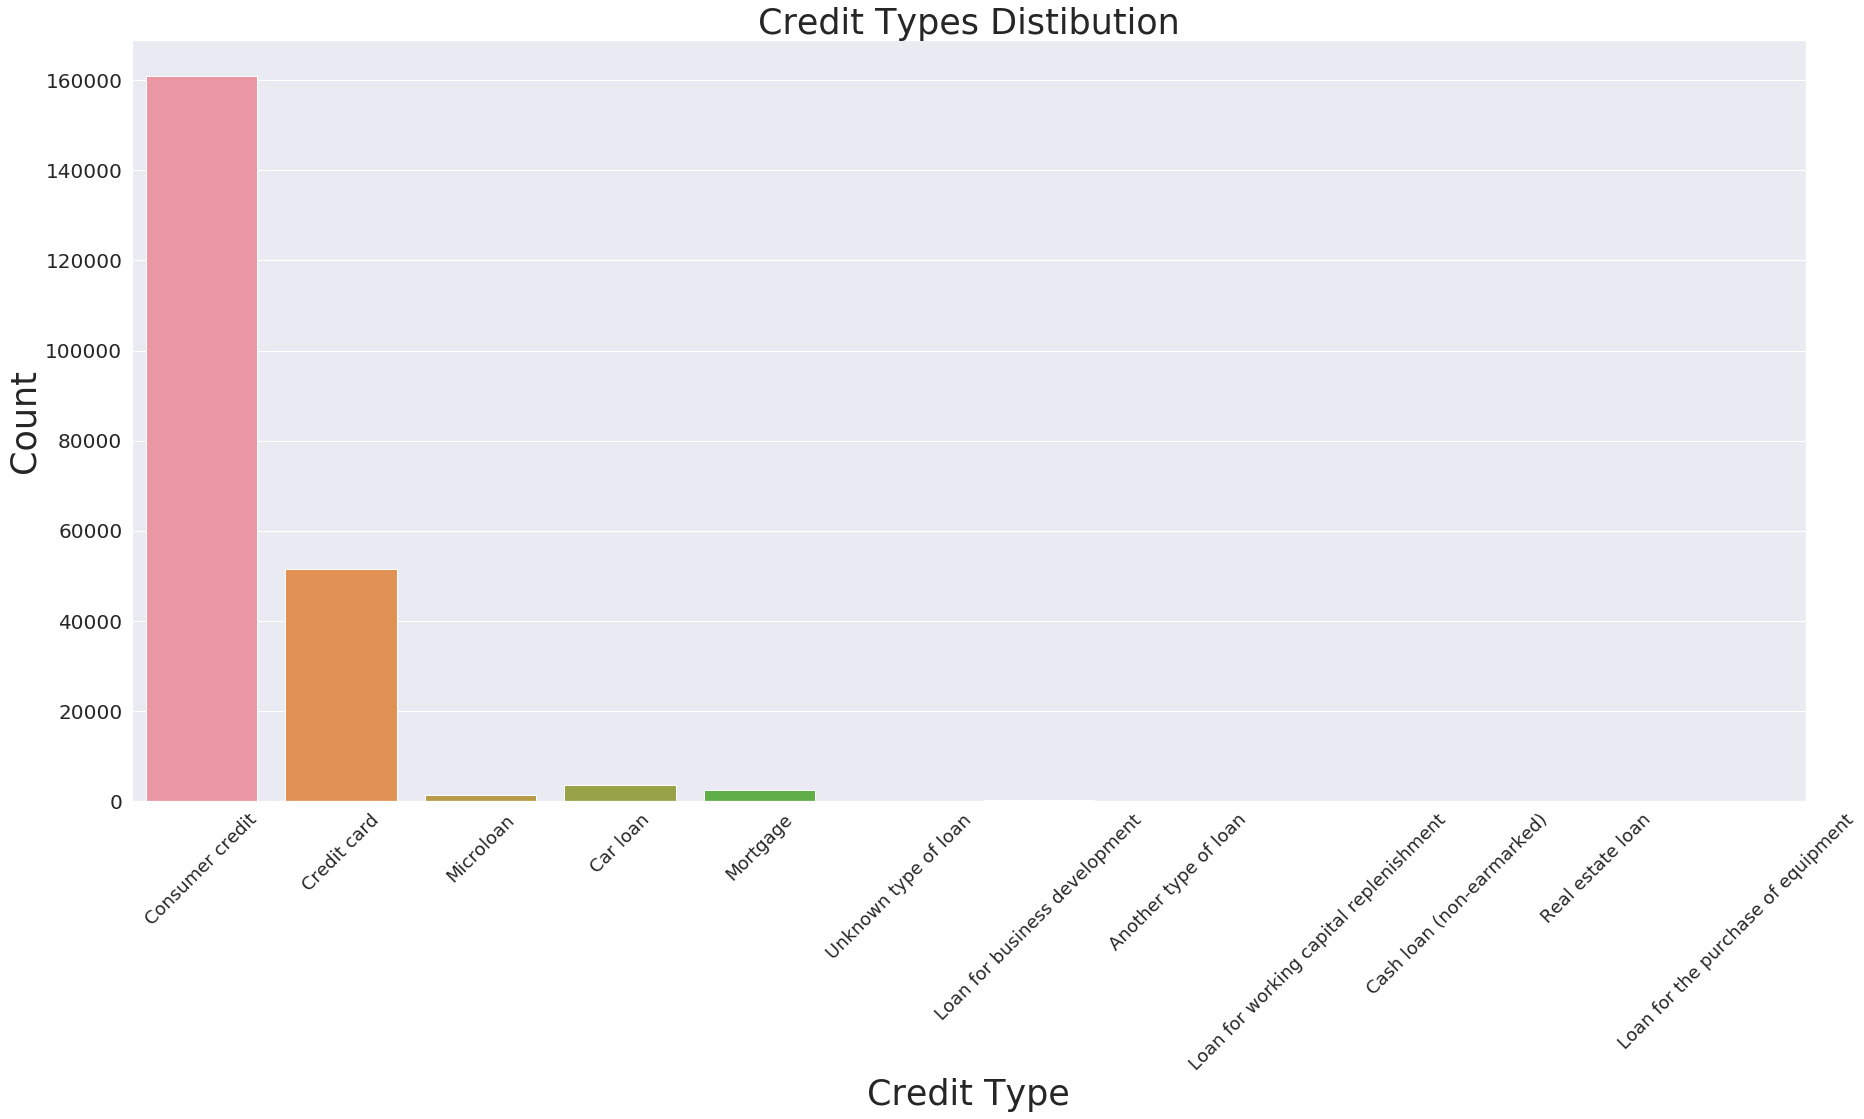

In [112]:
# Ploting disribution for credit_type
plt.figure(figsize=(30, 14))
sns.countplot(x='credit_type', data=accounts_test_df)
plt.title('Credit Types Distibution', fontsize=35)  
plt.xlabel('Credit Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=20)
plt.show()

In [113]:
#Getting the top 5 most frequent categories
top_categories = accounts_test_df['credit_type'].value_counts().head(5).index.tolist()

# Replace all other categories with 'other'
accounts_test_df['credit_type'] = accounts_test_df['credit_type'].apply(lambda x: x if x in top_categories else 'other_loan')

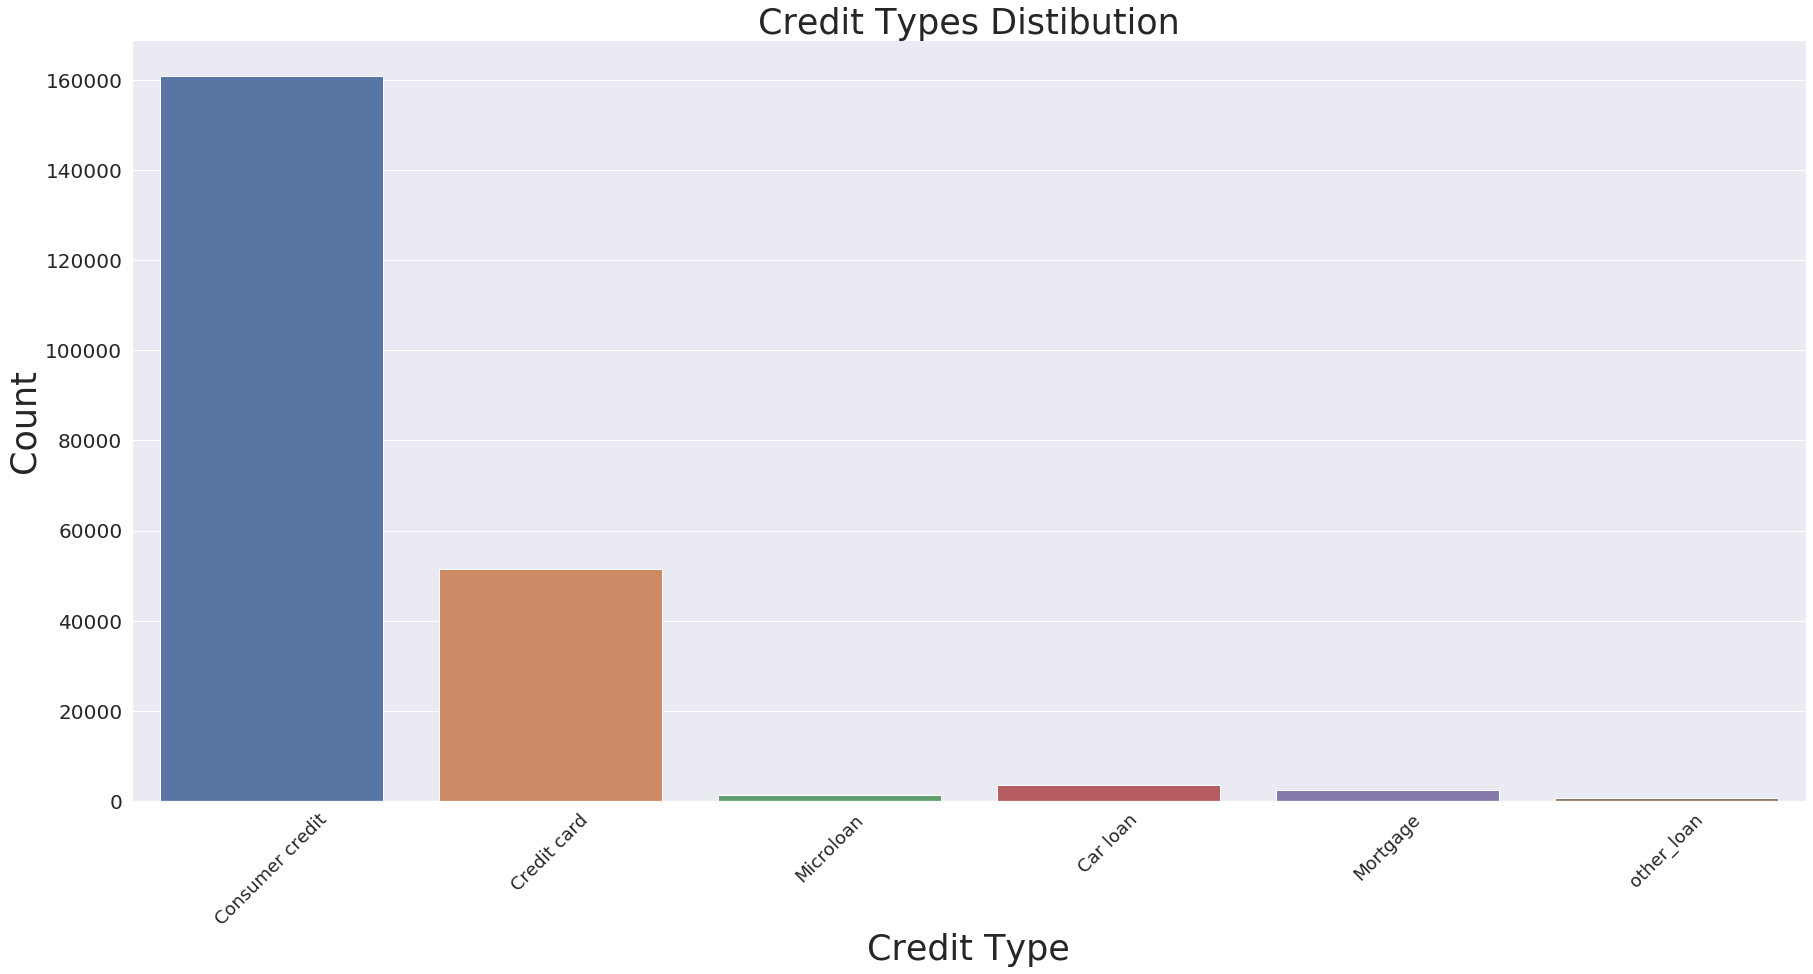

In [114]:
# Ploting disribution for credit_type
plt.figure(figsize=(30, 14))
sns.countplot(x='credit_type', data=accounts_test_df)
plt.title('Credit Types Distibution', fontsize=35)  
plt.xlabel('Credit Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=20)
plt.show()

In [115]:
accounts_test_df.credit_type.value_counts()

Consumer credit    160868
Credit card         51430
Car loan             3520
Mortgage             2411
Microloan            1239
other_loan            545
Name: credit_type, dtype: int64

In [116]:
credit_type_dummies = pd.get_dummies(accounts_test_df['credit_type'], prefix='credit_type')
# Concatenating the binary indicator columns with the original DataFrame
accounts_test_df = pd.concat([accounts_test_df, credit_type_dummies], axis=1)
# Dropping the original 'credit_type' column
accounts_test_df.drop(columns=['credit_type'], inplace=True)

In [117]:
accounts_test_df.columns

Index(['loan_amount', 'amount_overdue', 'open_date', 'closed_date',
       'payment_hist_string', 'uid', 'monthly_repayment_history',
       'avg_overdue_days', 'min_overdue_days', 'max_overdue_days',
       'overdue_count', 'total_payments', 'active_loan', 'inactive_loan',
       'loan_duration', 'credit_type_Car loan', 'credit_type_Consumer credit',
       'credit_type_Credit card', 'credit_type_Microloan',
       'credit_type_Mortgage', 'credit_type_other_loan'],
      dtype='object')

In [118]:
# Using aggregation functions for each feature to get data on 'uid' level
#consdering top 5 credit type + unknown and other_type loans
aggregation_functions = {
    'loan_amount': 'sum',
    'open_date':'count',
    'active_loan':'sum',
    'inactive_loan':'sum',
    'amount_overdue': 'sum',
    'avg_overdue_days': 'mean',
    'min_overdue_days': 'min',
    'max_overdue_days': 'max',
    'overdue_count': 'sum',
    'total_payments': 'sum',
    'loan_duration': 'mean',
    'credit_type_Consumer credit': 'sum',
    'credit_type_Credit card': 'sum',
    'credit_type_Microloan': 'sum',
    'credit_type_Mortgage': 'sum',
    'credit_type_Car loan': 'sum',
    'credit_type_other_loan': 'sum'
}
accounts_test_df2 = accounts_test_df.groupby('uid').agg(aggregation_functions).reset_index()
accounts_test_df2.rename(columns={'open_date': 'total_loans','loan_duration': 'avg_loan_duration'}, inplace=True)
accounts_test_df2.columns = accounts_test_df2.columns.str.replace('credit_type_', 'number_of_').str.replace(' ', '_')

In [119]:
accounts_test_df2.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan
0,AAA14437029,3736315.890,12,2,10,0.0,4.464286,0.0,285.0,10.0,239.0,808.000000,7,5,0,0,0,0
1,AAB12915377,408007.980,3,2,1,0.0,2.333333,0.0,36.0,2.0,71.0,1513.666667,2,1,0,0,0,0
2,AAB55088883,327394.485,6,2,4,0.0,0.000000,0.0,0.0,0.0,70.0,755.500000,5,1,0,0,0,0
3,AAB68152393,1806736.500,7,2,5,0.0,6.693878,0.0,228.0,8.0,137.0,941.857143,4,3,0,0,0,0
4,AAC29580834,2867536.800,5,3,2,0.0,0.000000,0.0,0.0,0.0,62.0,1101.600000,5,0,0,0,0,0


In [120]:
#converting average overdue days to upto 3 decimal places
accounts_test_df2['avg_overdue_days'] = np.round(accounts_test_df2['avg_overdue_days'],3)

In [121]:
#Checking whether customer has the given credit type or not
accounts_test_df2['consumer_credit']=np.where(accounts_test_df2['number_of_Consumer_credit']>0,1,0)
accounts_test_df2['credit_card']=np.where(accounts_test_df2['number_of_Credit_card']>0,1,0)
accounts_test_df2['car_loan']=np.where(accounts_test_df2['number_of_Car_loan']>0,1,0)
accounts_test_df2['mortgage']=np.where(accounts_test_df2['number_of_Mortgage']>0,1,0)
accounts_test_df2['microloan']=np.where(accounts_test_df2['number_of_Microloan']>0,1,0)
accounts_test_df2['other_loan']=np.where(accounts_test_df2['number_of_other_loan']>0,1,0)

In [122]:
accounts_test_df2.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan
0,AAA14437029,3736315.890,12,2,10,0.0,4.464,0.0,285.0,10.0,239.0,808.000000,7,5,0,0,0,0,1,1,0,0,0,0
1,AAB12915377,408007.980,3,2,1,0.0,2.333,0.0,36.0,2.0,71.0,1513.666667,2,1,0,0,0,0,1,1,0,0,0,0
2,AAB55088883,327394.485,6,2,4,0.0,0.000,0.0,0.0,0.0,70.0,755.500000,5,1,0,0,0,0,1,1,0,0,0,0
3,AAB68152393,1806736.500,7,2,5,0.0,6.694,0.0,228.0,8.0,137.0,941.857143,4,3,0,0,0,0,1,1,0,0,0,0
4,AAC29580834,2867536.800,5,3,2,0.0,0.000,0.0,0.0,0.0,62.0,1101.600000,5,0,0,0,0,0,1,0,0,0,0,0


In [123]:
accounts_test_df2.shape

(39572, 24)

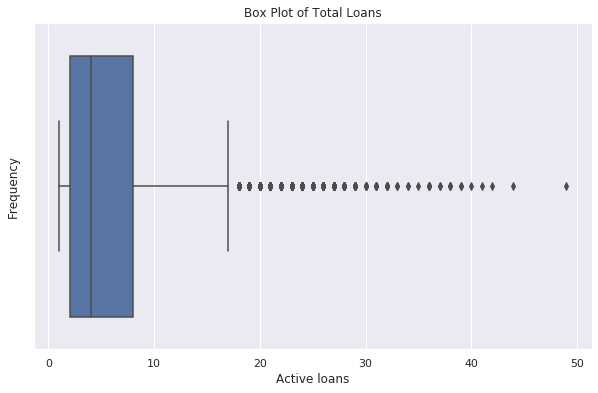

In [124]:
# Plotting box plot for number of  loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='total_loans', data=accounts_test_df2)
plt.title('Box Plot of Total Loans')
plt.xlabel('Active loans')
plt.ylabel('Frequency')
plt.show()

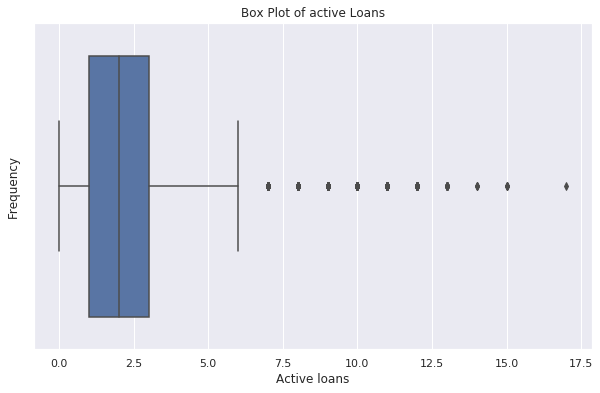

In [125]:
# Plotting box plot for number of active loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='active_loan', data=accounts_test_df2)
plt.title('Box Plot of active Loans')
plt.xlabel('Active loans')
plt.ylabel('Frequency')
plt.show()

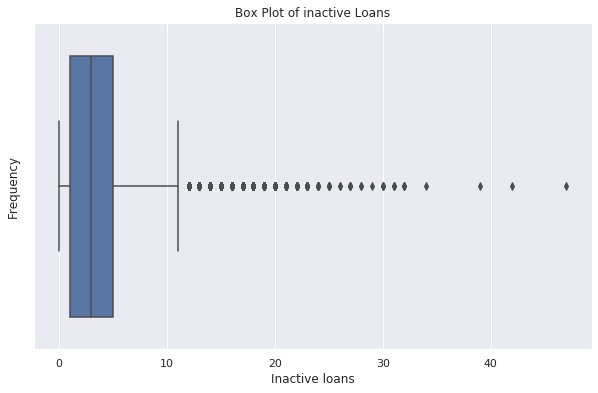

In [126]:
# Plotting box plot for number of active loans
plt.figure(figsize=(10, 6))
sns.boxplot(x='inactive_loan', data=accounts_test_df2)
plt.title('Box Plot of inactive Loans')
plt.xlabel('Inactive loans')
plt.ylabel('Frequency')
plt.show()

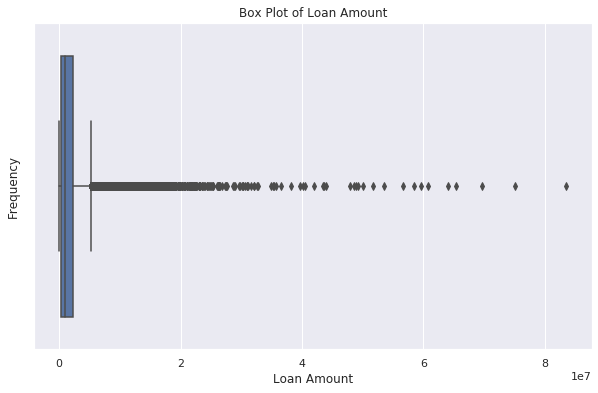

In [127]:
# Plotting box plot for loan amount
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_amount', data=accounts_test_df2)
plt.title('Box Plot of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

### Enquiry Data Feature engineering

In [128]:
enquiry_test_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029


In [129]:
print('Total Enquiry Data '+ str(enquiry_test_df.shape[0]))
print('Unique ids '+str(enquiry_test_df['uid'].nunique()))

Total Enquiry Data 337662
Unique ids 46127


In [130]:
# checking distibution for enquiry types
enquiry_test_df['enquiry_type'].value_counts()

Cash loans                                      53125
Revolving loans                                 21168
Car loan                                        17894
Credit card                                     17701
Another type of loan                            17619
Real estate loan                                17618
Mobile operator loan                            17599
Microloan                                       17589
Loan for purchase of shares (margin lending)    17575
Unknown type of loan                            17524
Loan for business development                   17523
Loan for working capital replenishment          17511
Mortgage                                        17504
Cash loan (non-earmarked)                       17467
Loan for the purchase of equipment              17467
Interbank credit                                17393
Consumer credit                                 17385
Name: enquiry_type, dtype: int64

In [131]:
# checking distibution for enquiry types in percentage
enquiry_test_df['enquiry_type'].value_counts(1)

Cash loans                                      0.157332
Revolving loans                                 0.062690
Car loan                                        0.052994
Credit card                                     0.052422
Another type of loan                            0.052179
Real estate loan                                0.052176
Mobile operator loan                            0.052120
Microloan                                       0.052091
Loan for purchase of shares (margin lending)    0.052049
Unknown type of loan                            0.051898
Loan for business development                   0.051895
Loan for working capital replenishment          0.051860
Mortgage                                        0.051839
Cash loan (non-earmarked)                       0.051729
Loan for the purchase of equipment              0.051729
Interbank credit                                0.051510
Consumer credit                                 0.051486
Name: enquiry_type, dtype: floa

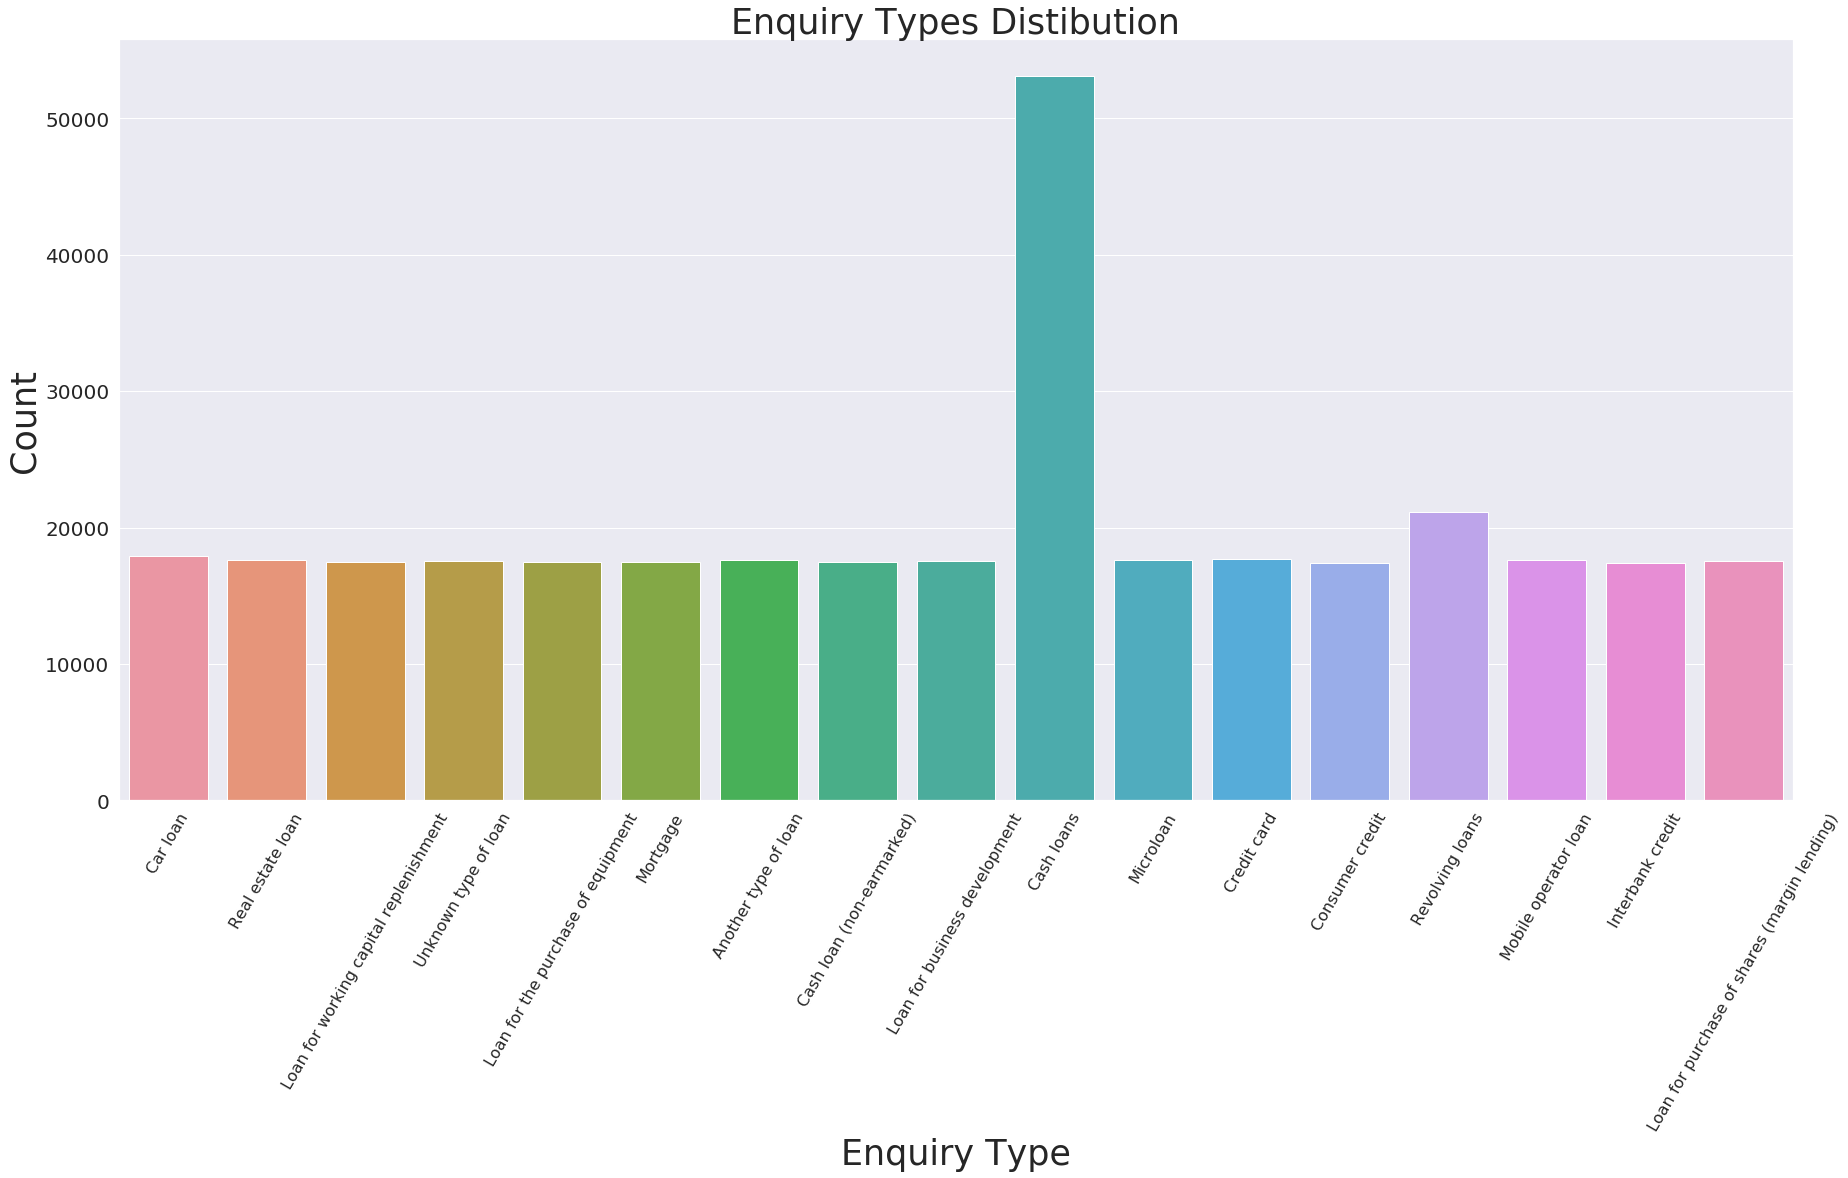

In [132]:
# Ploting distribution for 'enquiry_type'
plt.figure(figsize=(30, 14))
sns.countplot(x='enquiry_type', data=enquiry_test_df)
plt.title('Enquiry Types Distibution', fontsize=35)  
plt.xlabel('Enquiry Type', fontsize=35)  
plt.ylabel('Count', fontsize=35)
plt.xticks(rotation=60, fontsize=16)
plt.yticks(fontsize=20)
plt.show()

In [133]:
# Creating binary indicator columns for each category in 'enquiry_type'
enquiry_dummies = pd.get_dummies(enquiry_test_df['enquiry_type'], prefix='enquiry')
# Concatenating the binary indicator columns with the original DataFrame
enquiry_test_df = pd.concat([enquiry_test_df, enquiry_dummies], axis=1)
# Dropping the original 'enquiry_type' column
enquiry_test_df.drop(columns=['enquiry_type'], inplace=True)

In [134]:
enquiry_test_df.head()

,enquiry_amt,enquiry_date,uid,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan
0,143000,2020-12-13,AAA02107680,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,174000,2020-12-01,AAA14437029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,65000,2019-07-01,AAA14437029,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,118000,2020-08-05,AAA14437029,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,12000,2020-02-28,AAA14437029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [135]:
enquiry_test_df.columns

Index(['enquiry_amt', 'enquiry_date', 'uid', 'enquiry_Another type of loan',
       'enquiry_Car loan', 'enquiry_Cash loan (non-earmarked)',
       'enquiry_Cash loans', 'enquiry_Consumer credit', 'enquiry_Credit card',
       'enquiry_Interbank credit', 'enquiry_Loan for business development',
       'enquiry_Loan for purchase of shares (margin lending)',
       'enquiry_Loan for the purchase of equipment',
       'enquiry_Loan for working capital replenishment', 'enquiry_Microloan',
       'enquiry_Mobile operator loan', 'enquiry_Mortgage',
       'enquiry_Real estate loan', 'enquiry_Revolving loans',
       'enquiry_Unknown type of loan'],
      dtype='object')

In [136]:
# Using aggregation functions for each feature to get data on 'uid' level
enquiry_aggregation_functions = {
    'enquiry_amt': 'sum',
    'enquiry_date': 'count',
    'enquiry_Another type of loan': 'sum',
    'enquiry_Car loan': 'sum',
    'enquiry_Cash loan (non-earmarked)': 'sum',
    'enquiry_Cash loans': 'sum',
    'enquiry_Consumer credit': 'sum',
    'enquiry_Credit card': 'sum',
    'enquiry_Interbank credit': 'sum',
    'enquiry_Loan for business development': 'sum',
    'enquiry_Loan for purchase of shares (margin lending)': 'sum',
    'enquiry_Loan for the purchase of equipment': 'sum',
    'enquiry_Loan for working capital replenishment': 'sum',
    'enquiry_Microloan': 'sum',
    'enquiry_Mobile operator loan': 'sum',
    'enquiry_Mortgage': 'sum',
    'enquiry_Real estate loan': 'sum',
    'enquiry_Revolving loans': 'sum',
    'enquiry_Unknown type of loan': 'sum'
}

# Aggregating the features on uid level
enquiry_test_df2 = enquiry_test_df.groupby('uid').agg(enquiry_aggregation_functions).reset_index()

# Renaming columns
enquiry_test_df2.rename(columns={'enquiry_amt': 'total_enquiry_amount', 'enquiry_date': 'num_enquiries'}, inplace=True)


In [137]:
enquiry_test_df2.head()

,uid,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan
0,AAA02107680,143000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AAA14437029,369000,4,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0
2,AAB12915377,137000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,AAB55088883,1105000,14,1,0,1,5,0,0,0,1,0,1,0,1,0,1,1,0,2
4,AAB68152393,1987000,17,1,0,0,2,1,1,1,2,1,1,2,0,1,0,1,2,1


In [138]:
#checking shape of final enquiry data
enquiry_test_df2.shape

(46127, 20)

In [139]:
#checking shape of final account data
accounts_test_df2.shape

(39572, 24)

In [140]:
#merging all dataframes together
df_test=pd.merge(accounts_test_df2,enquiry_test_df2,on='uid')
df_test = df_test.merge(flag_test_df, on='uid')
df_test.shape

(39572, 44)

In [141]:
# Checking our final dataframe 
df_test.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan,NAME_CONTRACT_TYPE
0,AAA14437029,3736315.890,12,2,10,0.0,4.464,0.0,285.0,10.0,239.0,808.000000,7,5,0,0,0,0,1,1,0,0,0,0,369000,4,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,Cash loans
1,AAB12915377,408007.980,3,2,1,0.0,2.333,0.0,36.0,2.0,71.0,1513.666667,2,1,0,0,0,0,1,1,0,0,0,0,137000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Cash loans
2,AAB55088883,327394.485,6,2,4,0.0,0.000,0.0,0.0,0.0,70.0,755.500000,5,1,0,0,0,0,1,1,0,0,0,0,1105000,14,1,0,1,5,0,0,0,1,0,1,0,1,0,1,1,0,2,Cash loans
3,AAB68152393,1806736.500,7,2,5,0.0,6.694,0.0,228.0,8.0,137.0,941.857143,4,3,0,0,0,0,1,1,0,0,0,0,1987000,17,1,0,0,2,1,1,1,2,1,1,2,0,1,0,1,2,1,Cash loans
4,AAC29580834,2867536.800,5,3,2,0.0,0.000,0.0,0.0,0.0,62.0,1101.600000,5,0,0,0,0,0,1,0,0,0,0,0,158000,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Cash loans


In [142]:
# calculating loan to enquiry ratio
df_test['loan_enquiry_ratio'] = np.round((df_test['total_loans'] / df_test['num_enquiries']), 4)
# adding overdue percentage to check out of all payments in how much payments customer failed to repay on time 
df_test['overdue_perct'] = np.round((df_test['overdue_count'] / df_test['total_payments']) * 100, 2)

In [143]:
# Calculating the sum of missing values for each column
missing_values_count = df_test.isna().sum()
# Filtering out columns with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0]
print(columns_with_missing_values)

avg_overdue_days    133
min_overdue_days    133
max_overdue_days    133
overdue_perct       133
dtype: int64


In [144]:
# filling null values with a number because by replacing it with mean/dropping rows,there was slight decrease in perofrmance
df_test.fillna(-9999, inplace=True)

In [145]:
contract_type_dummies = pd.get_dummies(df_test['NAME_CONTRACT_TYPE'], prefix='contract_type')
# Concatenate the binary indicator columns with the original DataFrame
df_test = pd.concat([df_test, contract_type_dummies], axis=1)
# Drop the original 'credit_type' column
df_test.drop(columns=['NAME_CONTRACT_TYPE'], inplace=True)

In [146]:
# checking the data size
df_test.shape

(39572, 47)

In [147]:
#summary statistics
df_test.describe()

,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan,loan_enquiry_ratio,overdue_perct,contract_type_Cash loans,contract_type_Revolving loans
count,3.957200e+04,39572.000000,39572.000000,39572.000000,3.957200e+04,39572.00000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,3.957200e+04,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000,39572.000000
mean,1.934382e+06,5.559815,2.062974,3.496841,1.626409e+02,-32.46062,-33.605378,0.426615,1.542050,90.671283,992.794735,4.065198,1.299656,0.031310,0.060927,0.088952,0.013772,0.938643,0.648994,0.073916,0.055772,0.012888,0.011624,8.493849e+05,7.308855,0.381684,0.386207,0.376403,1.153796,0.376529,0.381659,0.375493,0.379157,0.378904,0.377439,0.379966,0.381381,0.381810,0.380471,0.382543,0.455170,0.380244,2.037166,-31.869651,0.906120,0.093880
std,3.039935e+06,4.341898,1.795819,3.357471,1.162171e+04,578.80937,578.712509,588.262405,3.861443,84.919631,519.716271,3.459370,1.505750,0.402671,0.263816,0.345547,0.145653,0.239986,0.477291,0.261637,0.229483,0.112792,0.107189,9.430708e+05,6.977846,0.707099,0.705731,0.694722,1.516781,0.693506,0.708879,0.694414,0.698000,0.703617,0.699292,0.698175,0.701162,0.703824,0.702592,0.701357,0.850467,0.703056,2.973947,578.830700,0.291665,0.291665
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,-9999.00000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.039000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023800,-9999.000000,0.000000,0.000000
25%,3.375000e+05,2.000000,1.000000,1.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,28.000000,636.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.940000e+05,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333300,0.000000,1.000000,0.000000
50%,9.611739e+05,4.000000,2.000000,3.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,66.000000,943.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.550000e+05,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2.304470e+06,8.000000,3.000000,5.000000,0.000000e+00,0.41700,0.000000,23.000000,1.000000,127.000000,1305.541667,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.162000e+06,

In [148]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39572 entries, 0 to 39571
Data columns (total 47 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   uid                                                   39572 non-null  object 
 1   loan_amount                                           39572 non-null  float64
 2   total_loans                                           39572 non-null  int64  
 3   active_loan                                           39572 non-null  int64  
 4   inactive_loan                                         39572 non-null  int64  
 5   amount_overdue                                        39572 non-null  float64
 6   avg_overdue_days                                      39572 non-null  float64
 7   min_overdue_days                                      39572 non-null  float64
 8   max_overdue_days                                      39

## Testing on unseen data

In [149]:
# Loading saved Gradientboost model
loaded_gb_model = joblib.load('gradient_boosting_model.pkl')

In [150]:
# Predicting results on unseen data
X_unseen=df_test[selected_features]
unseen_data_probabilities = loaded_gb_model.predict_proba(X_unseen)
# Accessing probabilities for the positive class
positive_class_probabilities = unseen_data_probabilities[:, 1]

In [151]:
#Joining the predictions with uid
prob_df = pd.DataFrame(positive_class_probabilities,columns=['pred'])
# Joining the probabilities DataFrame with 'df_test' based on index
prob_df_test= pd.merge(df_test, prob_df, left_index=True, right_index=True)
prob_df_test.head()

,uid,loan_amount,total_loans,active_loan,inactive_loan,amount_overdue,avg_overdue_days,min_overdue_days,max_overdue_days,overdue_count,total_payments,avg_loan_duration,number_of_Consumer_credit,number_of_Credit_card,number_of_Microloan,number_of_Mortgage,number_of_Car_loan,number_of_other_loan,consumer_credit,credit_card,car_loan,mortgage,microloan,other_loan,total_enquiry_amount,num_enquiries,enquiry_Another type of loan,enquiry_Car loan,enquiry_Cash loan (non-earmarked),enquiry_Cash loans,enquiry_Consumer credit,enquiry_Credit card,enquiry_Interbank credit,enquiry_Loan for business development,enquiry_Loan for purchase of shares (margin lending),enquiry_Loan for the purchase of equipment,enquiry_Loan for working capital replenishment,enquiry_Microloan,enquiry_Mobile operator loan,enquiry_Mortgage,enquiry_Real estate loan,enquiry_Revolving loans,enquiry_Unknown type of loan,loan_enquiry_ratio,overdue_perct,contract_type_Cash loans,contract_type_Revolving loans,pred
0,AAA14437029,3736315.890,12,2,10,0.0,4.464,0.0,285.0,10.0,239.0,808.000000,7,5,0,0,0,0,1,1,0,0,0,0,369000,4,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,3.0000,4.18,1,0,0.420870
1,AAB12915377,408007.980,3,2,1,0.0,2.333,0.0,36.0,2.0,71.0,1513.666667,2,1,0,0,0,0,1,1,0,0,0,0,137000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0000,2.82,1,0,0.539898
2,AAB55088883,327394.485,6,2,4,0.0,0.000,0.0,0.0,0.0,70.0,755.500000,5,1,0,0,0,0,1,1,0,0,0,0,1105000,14,1,0,1,5,0,0,0,1,0,1,0,1,0,1,1,0,2,0.4286,0.00,1,0,0.526476
3,AAB68152393,1806736.500,7,2,5,0.0,6.694,0.0,228.0,8.0,137.0,941.857143,4,3,0,0,0,0,1,1,0,0,0,0,1987000,17,1,0,0,2,1,1,1,2,1,1,2,0,1,0,1,2,1,0.4118,5.84,1,0,0.448126
4,AAC29580834,2867536.800,5,3,2,0.0,0.000,0.0,0.0,0.0,62.0,1101.600000,5,0,0,0,0,0,1,0,0,0,0,0,158000,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.5000,0.00,1,0,0.603839


In [152]:
# Makingsubset of Dataset in desired format uid,pred
df_final=prob_df_test[['uid','pred']]
df_final['pred']=np.round(df_final['pred'],3)
df_final.head()

,uid,pred
0,AAA14437029,0.421
1,AAB12915377,0.540
2,AAB55088883,0.526
3,AAB68152393,0.448
4,AAC29580834,0.604


In [155]:
df_final.to_csv('final_submission_Nirmit_Singh.csv',index=False)